<a href="https://colab.research.google.com/github/ChiragShetye/-Business-Case-Product-Sale-Forcasting/blob/main/Business_Case_Product_Sale_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import joblib

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [ ]:
train_file_id = '1ditFn_74EOsGnblf2nXr-Vx-I1mrCG42'
test_file_id = '1CclWDHsFLfCAuBbAv83_D5_XmeoRwWzl'

# Construct direct download URLs
train_url = f'https://drive.google.com/uc?id={train_file_id}'
test_url = f'https://drive.google.com/uc?id={test_file_id}'

# Load the CSVs using pandas
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

# Display first few rows
print(train_df.head())
print(test_df.head())


         ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1000001         1         S1            L3          R1  2018-01-01   
1  T1000002       253         S4            L2          R1  2018-01-01   
2  T1000003       252         S3            L2          R1  2018-01-01   
3  T1000004       251         S2            L3          R1  2018-01-01   
4  T1000005       250         S2            L3          R4  2018-01-01   

   Holiday Discount  #Order     Sales  
0        1      Yes       9   7011.84  
1        1      Yes      60  51789.12  
2        1      Yes      42  36868.20  
3        1      Yes      23  19715.16  
4        1      Yes      62  45614.52  
         ID  Store_id Store_Type Location_Type Region_Code        Date  \
0  T1188341       171         S4            L2          R3  2019-06-01   
1  T1188342       172         S1            L1          R1  2019-06-01   
2  T1188343       173         S4            L2          R1  2019-06-01   
3  T1188344       1

In [ ]:
train_df.sample(10)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
182760,T1182761,67,S2,L5,R1,2019-05-16,0,Yes,46,31935.0
83576,T1083577,345,S1,L1,R3,2018-08-17,1,No,39,27656.4
149633,T1149634,143,S3,L2,R3,2019-02-14,0,No,82,55956.0
168340,T1168341,258,S2,L4,R4,2019-04-07,0,Yes,52,35820.0
69482,T1069483,338,S4,L2,R1,2018-07-10,0,No,100,60858.0
178958,T1178959,32,S1,L1,R2,2019-05-06,0,No,45,33120.0
30811,T1030812,123,S4,L2,R3,2018-03-26,0,No,66,41763.0
38691,T1038692,77,S2,L5,R3,2018-04-17,0,No,23,14499.0
141257,T1141258,138,S1,L1,R1,2019-01-23,0,Yes,72,44586.0
104524,T1104525,275,S4,L1,R1,2018-10-14,0,Yes,108,64341.0


In [ ]:
test_df.sample(10)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
13732,T1202073,148,S1,L1,R2,2019-07-08,0,No
10546,T1198887,296,S1,L1,R1,2019-06-29,0,No
16340,T1204681,151,S1,L3,R2,2019-07-15,0,No
16399,T1204740,213,S1,L1,R2,2019-07-15,0,No
8543,T1196884,178,S3,L2,R3,2019-06-24,0,No
19807,T1208148,314,S1,L1,R2,2019-07-25,0,Yes
4355,T1192696,72,S1,L2,R3,2019-06-12,0,No
3169,T1191510,56,S2,L5,R3,2019-06-09,0,No
6115,T1194456,114,S3,L1,R4,2019-06-17,0,Yes
1339,T1189680,240,S3,L2,R3,2019-06-04,0,No


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [ ]:
## change store id and holidat to object.
train_df['Store_id'] = train_df['Store_id'].astype(str)
train_df['Holiday'] = train_df['Holiday'].astype(str)

In [ ]:
train_df.isnull().sum()

,0
ID,0
Store_id,0
Store_Type,0
Location_Type,0
Region_Code,0
Date,0
Holiday,0
Discount,0
#Order,0
Sales,0


In [ ]:
duplicates = train_df.duplicated()
duplicate_rows = train_df[train_df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [ID, Store_id, Store_Type, Location_Type, Region_Code, Date, Holiday, Discount, #Order, Sales]
Index: []


In [ ]:
num_duplicates = train_df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)


Number of duplicate rows: 0


In [ ]:
# Check where #Order or Sales is less than or equal to zero
invalid_rows = train_df[(train_df['#Order'] <= 0) | (train_df['Sales'] <= 0)]
print("Invalid rows:\n", invalid_rows)

Invalid rows:
               ID Store_id Store_Type Location_Type Region_Code        Date  \
23867   T1023868      311         S4            L2          R2  2018-03-07   
38143   T1038144      222         S4            L2          R2  2018-04-15   
90458   T1090459      233         S1            L3          R3  2018-09-05   
97301   T1097302      271         S1            L3          R2  2018-09-24   
97480   T1097481      271         S1            L3          R2  2018-09-25   
99489   T1099490       12         S1            L3          R2  2018-09-30   
99904   T1099905       12         S1            L3          R2  2018-10-01   
100215  T1100216       12         S1            L3          R2  2018-10-02   
112564  T1112565       39         S4            L1          R1  2018-11-05   
112853  T1112854       39         S4            L1          R1  2018-11-06   
113444  T1113445       39         S4            L1          R1  2018-11-07   
118972  T1118973      298         S4            L

In [ ]:
invalid_count = ((train_df['#Order'] <= 0) | (train_df['Sales'] <= 0)).sum()
print("Number of invalid rows:", invalid_count)

Number of invalid rows: 19


In [ ]:
invalid_rows

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
23867,T1023868,311,S4,L2,R2,2018-03-07,0,No,0,0.0
38143,T1038144,222,S4,L2,R2,2018-04-15,1,No,0,0.0
90458,T1090459,233,S1,L3,R3,2018-09-05,0,No,0,0.0
97301,T1097302,271,S1,L3,R2,2018-09-24,0,No,0,0.0
97480,T1097481,271,S1,L3,R2,2018-09-25,0,No,0,0.0
99489,T1099490,12,S1,L3,R2,2018-09-30,0,No,0,0.0
99904,T1099905,12,S1,L3,R2,2018-10-01,0,No,0,0.0
100215,T1100216,12,S1,L3,R2,2018-10-02,1,No,0,0.0
112564,T1112565,39,S4,L1,R1,2018-11-05,0,No,0,0.0
112853,T1112854,39,S4,L1,R1,2018-11-06,1,No,0,0.0


In [ ]:
# Assuming your DataFrame is named df and 'Date' column is in datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])  # Ensure proper datetime format

# Create additional time-based columns
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Week'] = train_df['Date'].dt.isocalendar().week
train_df['Day'] = train_df['Date'].dt.day

# Calculate Average Order Value (only where #Order is not zero)
train_df['Avg_Order_Value'] = train_df.apply(lambda row: row['Sales'] / row['#Order'] if row['#Order'] != 0 else 0, axis=1)

# Optional: Replace 0 with NaN to ignore invalid avg order values in aggregation
# df['Avg_Order_Value'] = df['Avg_Order_Value'].replace(0, np.nan)


In [ ]:
train_df.sample(15)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,Year,Month,Week,Day,Avg_Order_Value
14228,T1014229,23,S1,L1,R4,2018-02-08,0,Yes,55,40377.0,2018,2,6,8,734.127273
67924,T1067925,226,S2,L5,R4,2018-07-06,0,Yes,63,42996.0,2018,7,27,6,682.476190
174082,T1174083,280,S4,L2,R2,2019-04-22,0,Yes,127,72948.0,2019,4,17,22,574.393701
85660,T1085661,190,S3,L3,R1,2018-08-23,0,Yes,81,42402.0,2018,8,34,23,523.481481
180886,T1180887,242,S4,L1,R1,2019-05-11,0,No,84,47898.0,2019,5,19,11,570.214286
56570,T1056571,49,S4,L1,R2,2018-06-04,0,Yes,100,61386.0,2018,6,23,4,613.860000
41751,T1041752,361,S1,L3,R1,2018-04-25,0,No,52,28344.0,2018,4,17,25,545.076923
109552,T1109553,334,S3,L2,R2,2018-10-28,0,No,70,42900.0,2018,10,43,28,612.857143
37010,T1037011,11,S4,L2,R1,2018-04-12,0,No,93,52017.0,2018,4,15,12,559.322581
148751,T1148752,253,S4,L2,R1,2019-02-12,0,No,71,38274.0,2019,2,7,12,539.070423


### 🔍 Data Exploration & Preprocessing Summary

#### ✅ Initial Observations
- Loaded dataset `train_df` with **188,340 records** and **10 columns**.
- Converted `Store_id` and `Holiday` to `object` type.
- No null values found — dataset is clean.

#### 🔁 Duplicate Check
- No duplicate rows were found in the dataset.

#### ⚠️ Invalid Data Checks
- Rows found with `#Order <= 0` or `Sales <= 0`.
  - Indicates zero-sales transactions, which may mean:
    - Store was open but no orders.
    - Stockouts or technical issues.
    - Placeholder/missing data entries.

#### 📅 Date Feature Engineering
- Converted `Date` to `datetime`.
- Extracted time-based features: `Year`, `Month`, `Week`, `Day`.

#### 💰 Average Order Value (AOV)
- Created `Avg_Order_Value = Sales / #Order`.
- Handled division by zero by setting AOV to `0` when `#Order = 0`.




### 🧠 Key Insights
- Data is clean and ready for analysis.
- Zero-sales rows may require special attention or filtering.
- Time-based columns enable trend/seasonality analysis.
- AOV helps understand spending behavior per order.

## 📊 Univariate Analysis

Data Shape: (188340, 15)

Data Types:
 ID                         object
Store_id                   object
Store_Type                 object
Location_Type              object
Region_Code                object
Date               datetime64[ns]
Holiday                    object
Discount                   object
#Order                      int64
Sales                     float64
Year                        int32
Month                       int32
Week                       UInt32
Day                         int32
Avg_Order_Value           float64
dtype: object

Missing Values:
 ID                 0
Store_id           0
Store_Type         0
Location_Type      0
Region_Code        0
Date               0
Holiday            0
Discount           0
#Order             0
Sales              0
Year               0
Month              0
Week               0
Day                0
Avg_Order_Value    0
dtype: int64


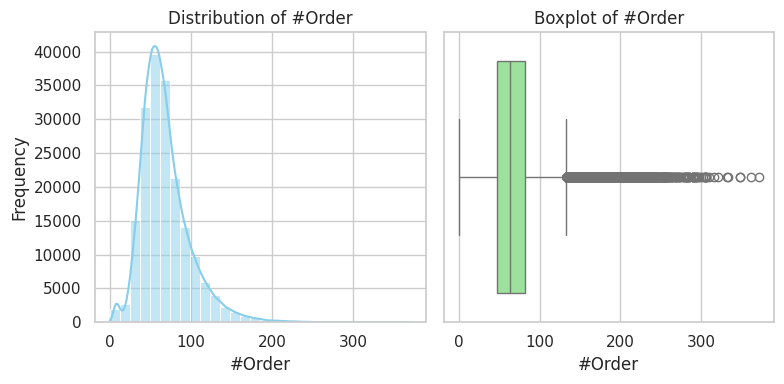

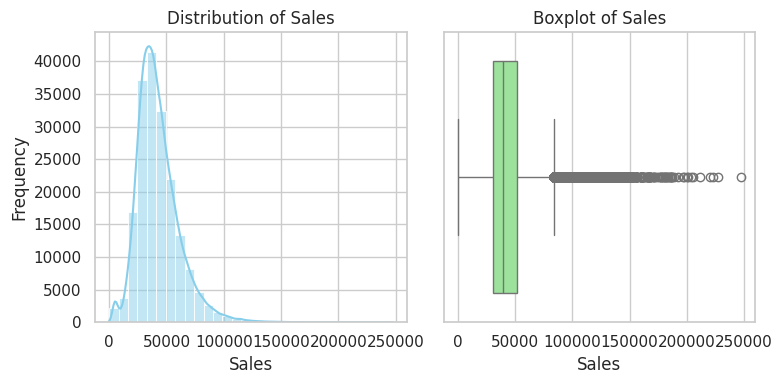

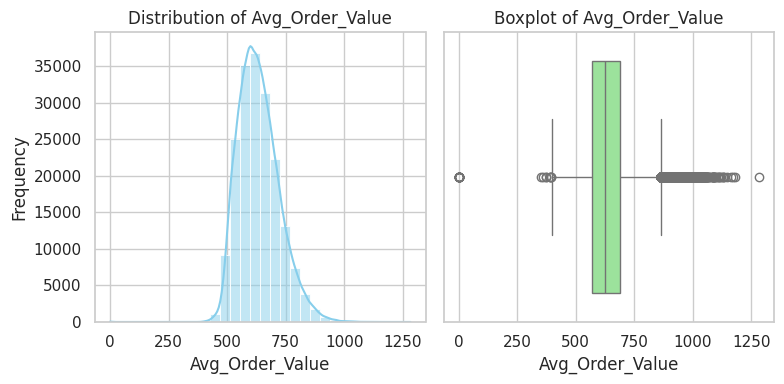

In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Basic checks
print("Data Shape:", train_df.shape)
print("\nData Types:\n", train_df.dtypes)
print("\nMissing Values:\n", train_df.isnull().sum())

# numerical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns


# ---------- UNIVARIATE ANALYSIS: NUMERICAL VARIABLES ---------- #

for col in numerical_cols:
    plt.figure(figsize=(8, 4))

    # Histogram + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(train_df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


### 📊 Univariate Analysis – Numerical Features

#### 1. Histogram Plots (Distribution Check)
- Plotted histograms for:
  - `#Order`
  - `Sales`
  - `Avg_Order_Value`
- **Observation:** All three variables show approximately **normal distribution** patterns, especially after removing extreme outliers.
  - Indicates these variables are well-behaved for modeling.
  - Helps justify use of statistical methods that assume normality.

#### 2. Boxplots (Outlier Detection)
- Created **side-by-side boxplots** for the above variables.
- **Insights:**
  - Some outliers are present, particularly in `Sales` and `Avg_Order_Value`.
    - High sales spikes likely due to bulk orders or promotional periods.
  - `#Order` has fewer extreme values, suggesting a more consistent pattern.

---

### ✅ Key Takeaways from Univariate Analysis
- Data shows **normal-like distribution**, making it suitable for many statistical techniques.
- Boxplots help **visualize skewness and detect outliers**, useful for further filtering or capping.
- Outlier handling may improve modeling performance, especially for regression or time-series forecasting.



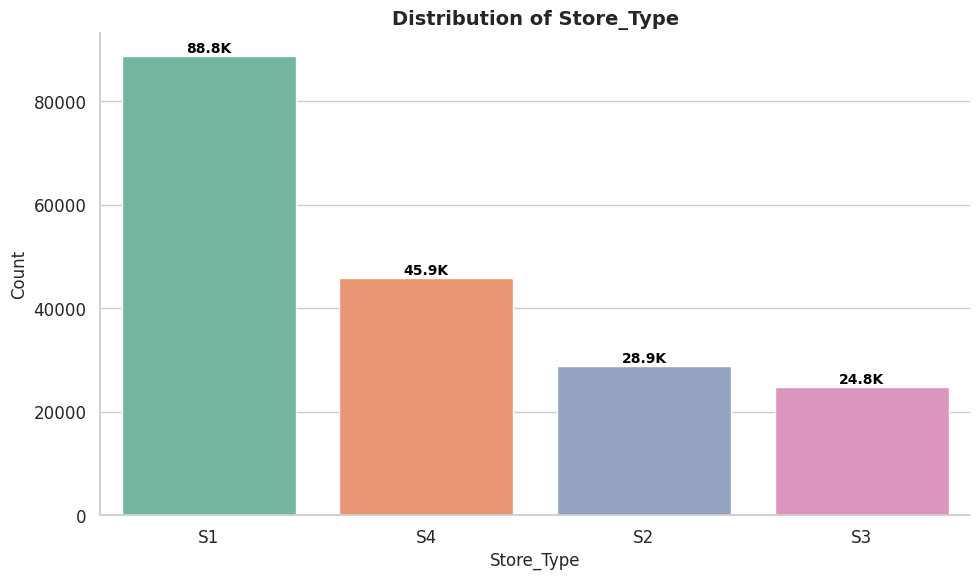

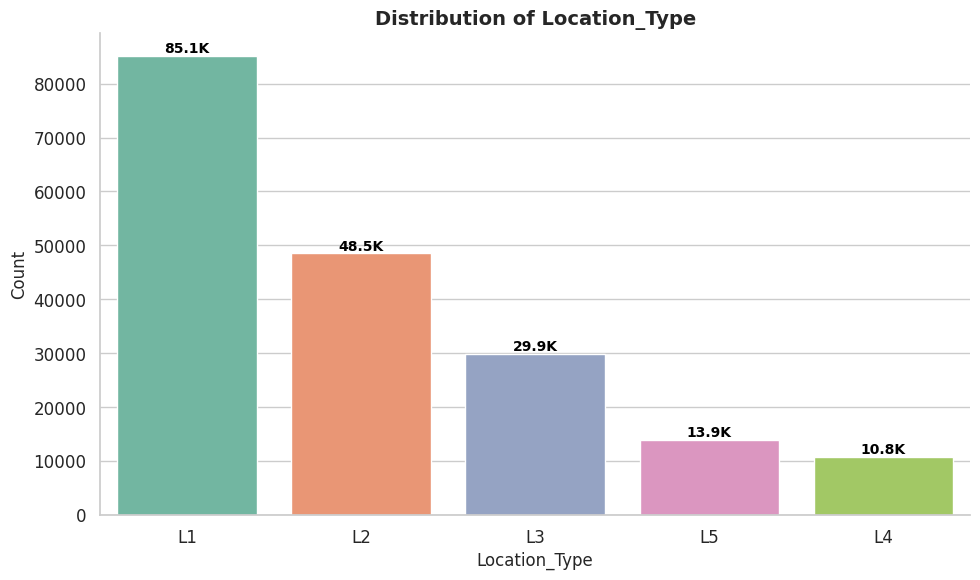

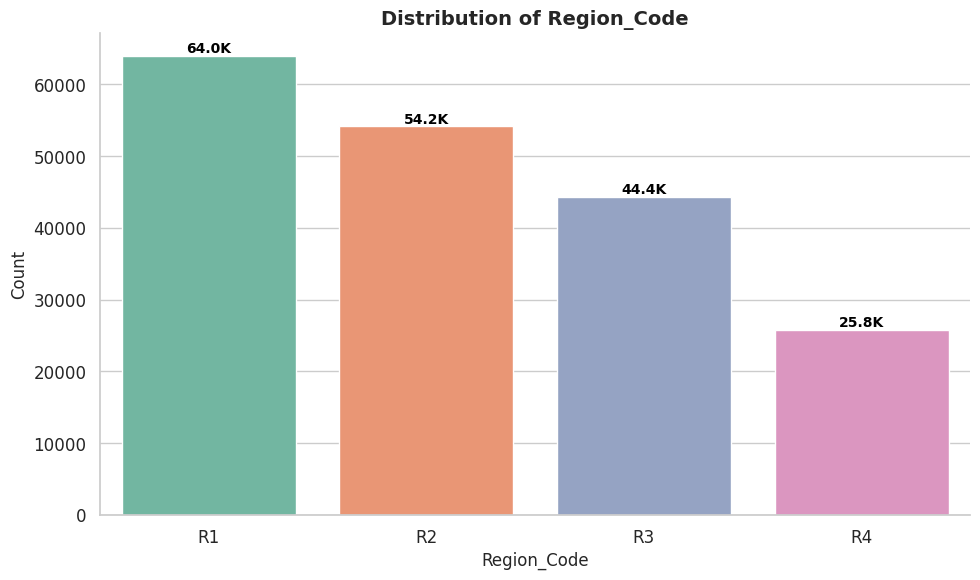

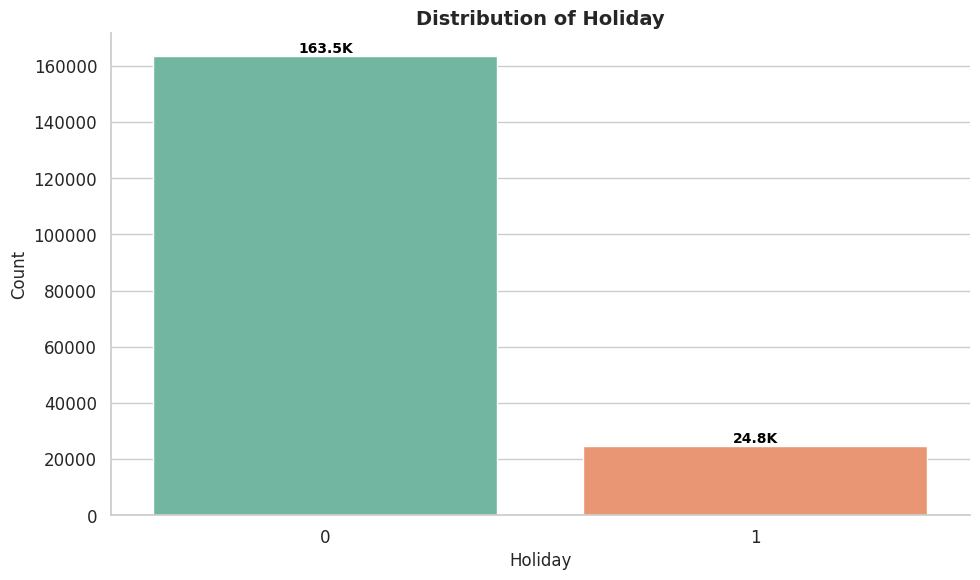

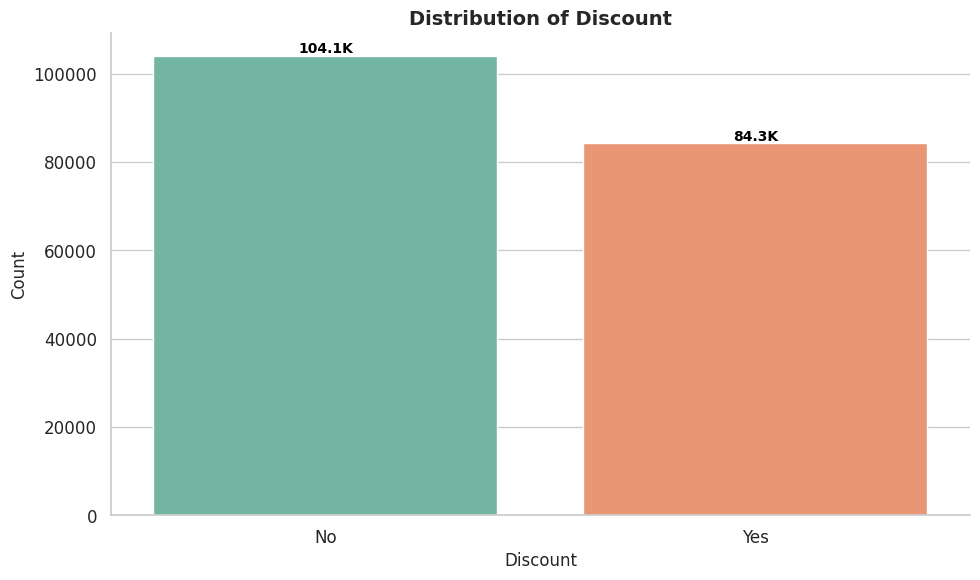

In [ ]:
# ---------- UNIVARIATE ANALYSIS: CATEGORICAL VARIABLES ---------- #

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Set Seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.1)

# Format large numbers (K, M)
def format_number(n):
    if n >= 1e6:
        return f'{n / 1e6:.1f}M'
    elif n >= 1e3:
        return f'{n / 1e3:.1f}K'
    else:
        return str(n)

# Identify low-cardinality categorical columns (excluding 'Store_id')
categorical_cols = [
    col for col in train_df.select_dtypes(include='object').columns
    if train_df[col].nunique() <= 20 and col != 'Store_id'
]

# Plot each categorical variable
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    order = train_df[col].value_counts().index
    ax = sns.countplot(data=train_df, x=col, order=order, palette='Set2')

    # Add value labels above bars
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(
            format_number(count),
            (p.get_x() + p.get_width() / 2., p.get_height() + 0.01),
            ha='center', va='bottom',
            fontsize=10, fontweight='bold', color='black'
        )

    # Set title and labels
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


### 🧩 Univariate Analysis – Categorical Features

#### 🏪 Store Type Distribution
- **Store Type S1** dominates with ~88.8K orders — more than double that of S4 (~45.9K), S2 (~28.9K), and S3 (~24.8K).
- This suggests S1 stores are either:
  - Strategically located in high-footfall areas,
  - Or have better customer reach or product availability.
- Useful for prioritizing inventory allocation or promotional targeting.

#### 📍 Location Type Distribution
- **L1 locations** lead with ~85.1K orders, followed by L2 (48.2K) and L3 (29.9K).
- **L4 and L5** have significantly lower volume, hinting these may be:
  - Niche or emerging markets,
  - Or have limited operational capacity.
- For forecasting: L1 and L2 locations will heavily influence aggregate demand predictions.

#### 🌍 Region Code Distribution
- **Region R1** accounts for the highest order volume (~64.04K), followed by R2 (~54.2K), R3 (~44.4K), and R4 (~25.8K).
- Indicates stronger performance and possible customer loyalty in R1 and R2 regions.
- Regional performance differences should be factored into seasonal demand forecasting.

#### 🎉 Holiday Indicator
- Majority of orders (~165.5K) occurred on **non-holiday (weekday)** dates, with only ~24.8K during holidays.
- Indicates customer behavior is more predictable on regular weekdays.
- Holiday sales forecasting should account for this skew, as holidays may not significantly boost volume.

#### 💸 Discount Impact
- **Orders without discount (~104.4K)** exceed those with discounts (~84.3K).
- Suggests that discounts are not the primary driver of sales — product necessity or convenience might be stronger factors.
- For forecasting:
  - Baseline demand can be predicted with minimal reliance on promotional triggers.
  - Price elasticity might be low in this context.

---

### 🔮 Forecasting Implications
- Focus forecasting efforts on **S1 stores**, **L1 & L2 locations**, and **R1–R2 regions** to capture the bulk of the demand.
- Separate modeling for holidays and weekends may not be necessary unless holiday campaigns are enhanced.
- Discount strategies can be optimized — consider targeting them to underperforming store/location segments rather than across the board.


## 🔁 Bivariate Analysis

##📦 Sales vs Discount



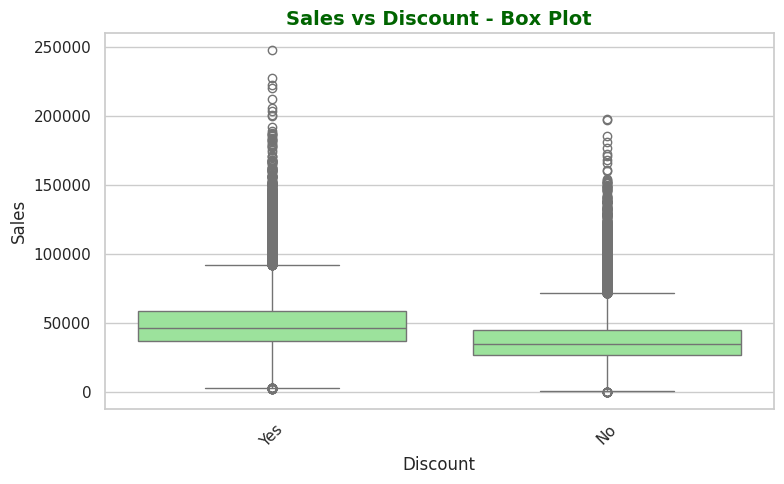

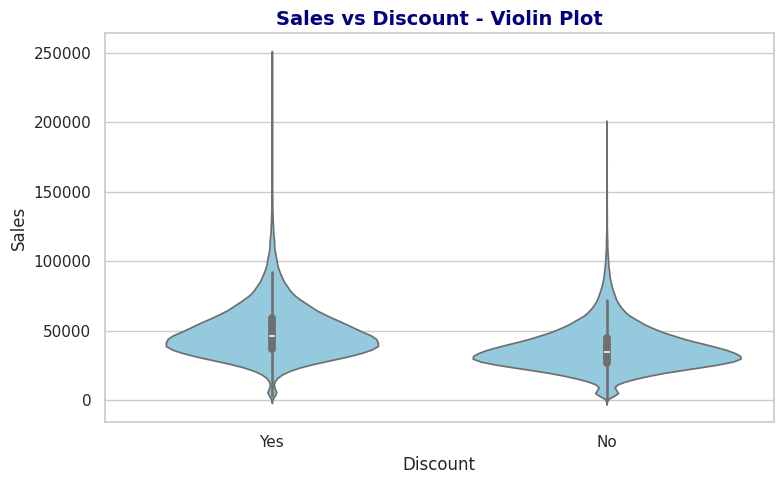

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Box Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Discount', y='Sales', data=train_df, color='lightgreen')
plt.title("Sales vs Discount - Box Plot", fontsize=14, fontweight='bold', color='darkgreen')
plt.xlabel("Discount", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Violin Plot
plt.figure(figsize=(8, 5))
sns.violinplot(x='Discount', y='Sales', data=train_df, color='skyblue')
plt.title("Sales vs Discount - Violin Plot", fontsize=14, fontweight='bold', color='navy')
plt.xlabel("Discount", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 🏪 Sales by Store Type



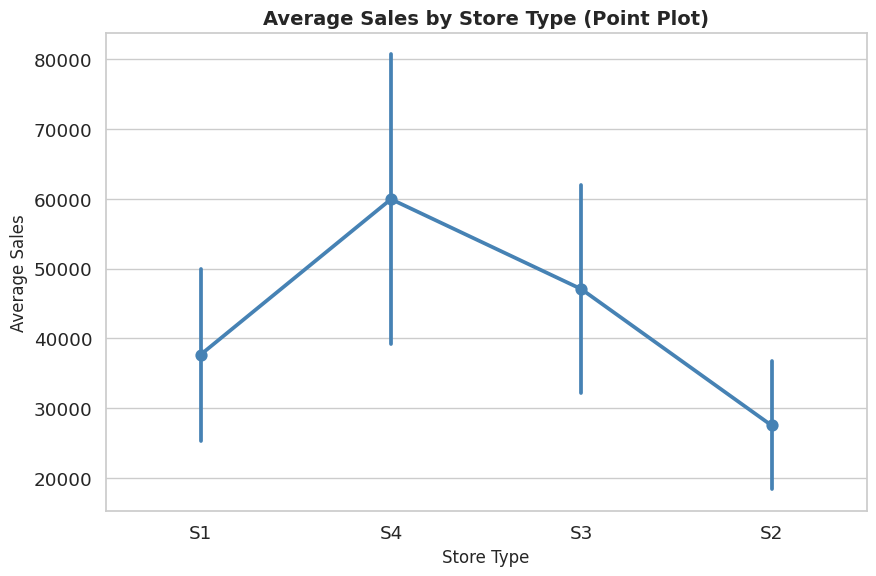

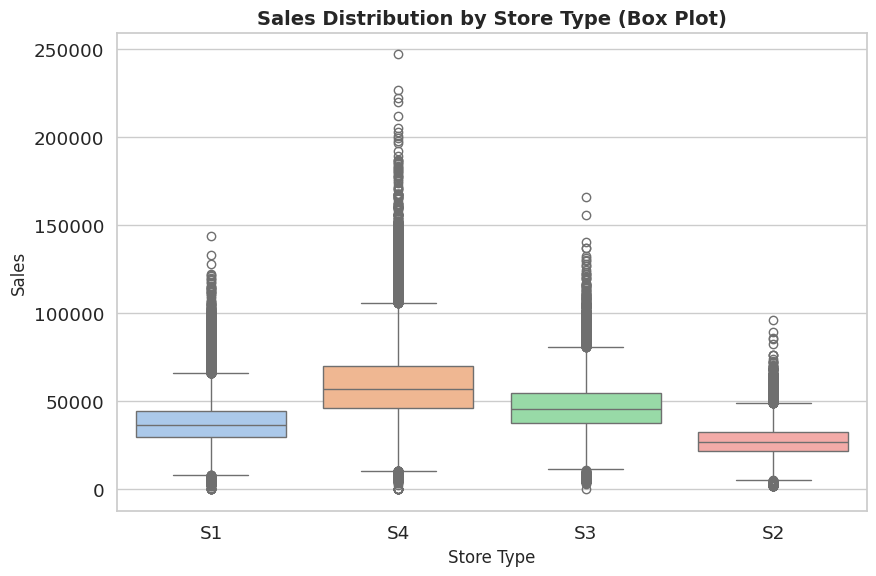

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid", font_scale=1.2)

# ----- 1. Point Plot: Mean Sales Trend by Store Type -----
plt.figure(figsize=(9, 6))
sns.pointplot(x='Store_Type', y='Sales', data=train_df, estimator='mean', ci='sd', markers='o', linestyles='-', color='steelblue')
plt.title("Average Sales by Store Type (Point Plot)", fontsize=14, fontweight='bold')
plt.xlabel("Store Type", fontsize=12)
plt.ylabel("Average Sales", fontsize=12)
plt.tight_layout()
plt.show()

# ----- 2. Box Plot: Distribution of Sales by Store Type -----
plt.figure(figsize=(9, 6))
sns.boxplot(x='Store_Type', y='Sales', data=train_df, palette='pastel')
plt.title("Sales Distribution by Store Type (Box Plot)", fontsize=14, fontweight='bold')
plt.xlabel("Store Type", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.tight_layout()
plt.show()


##🌎 Sales by Region Code


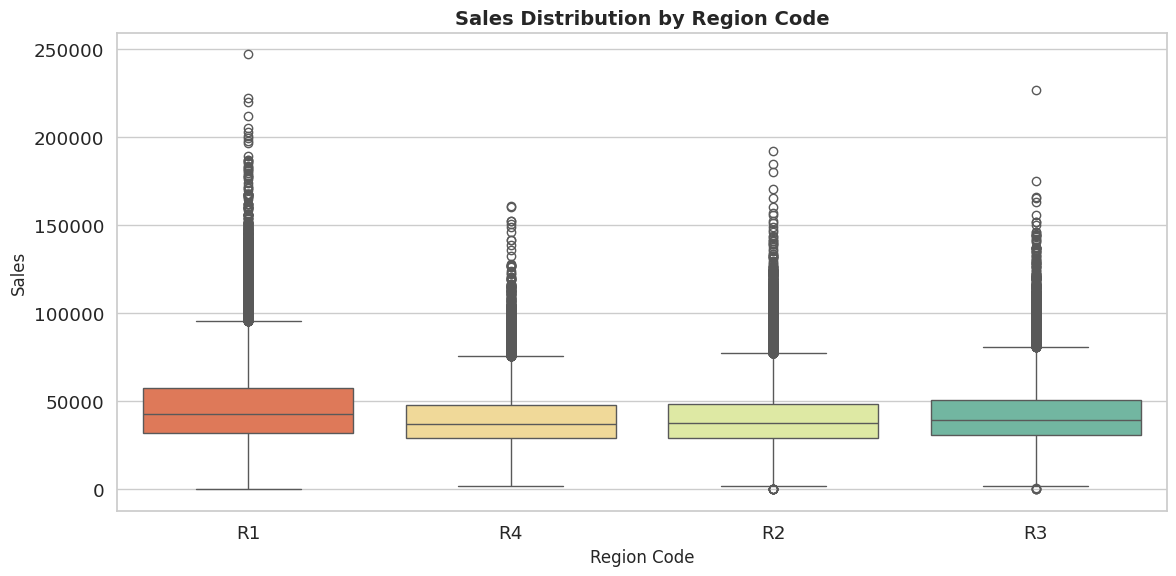

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual theme
sns.set_theme(style="whitegrid", font_scale=1.2)

# Static Box Plot: Sales by Region Code
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Region_Code',
    y='Sales',
    data=train_df,
    palette='Spectral'
)
plt.title("Sales Distribution by Region Code", fontsize=14, fontweight='bold')
plt.xlabel("Region Code", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 🔢 Sales vs Number of Orders


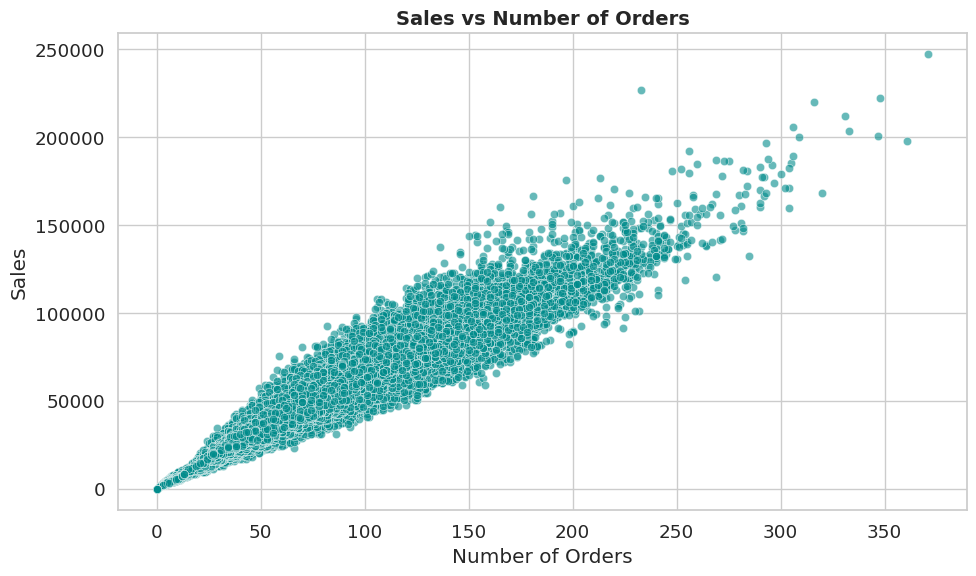

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the theme
sns.set_theme(style="whitegrid", font_scale=1.2)

# Scatter Plot: Sales vs Number of Orders
plt.figure(figsize=(10, 6))
sns.scatterplot(x='#Order', y='Sales', data=train_df, color='darkcyan', alpha=0.6)
plt.title("Sales vs Number of Orders", fontsize=14, fontweight='bold')
plt.xlabel("Number of Orders")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


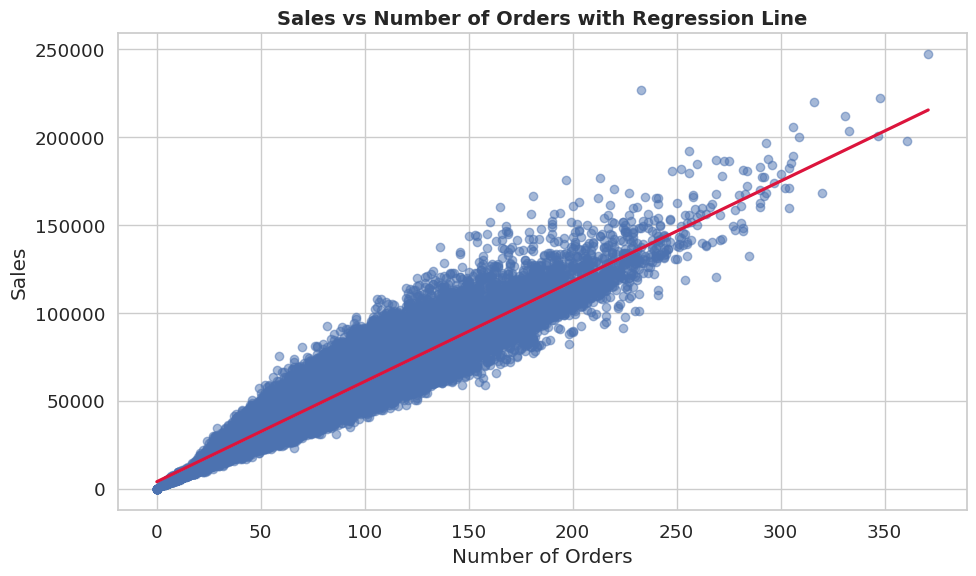

In [ ]:
# Regression Plot: Sales vs Orders
plt.figure(figsize=(10, 6))
sns.regplot(x='#Order', y='Sales', data=train_df, scatter_kws={'alpha': 0.5}, line_kws={"color": "crimson"})
plt.title("Sales vs Number of Orders with Regression Line", fontsize=14, fontweight='bold')
plt.xlabel("Number of Orders")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


## 📊 Sales vs Avg Order Value

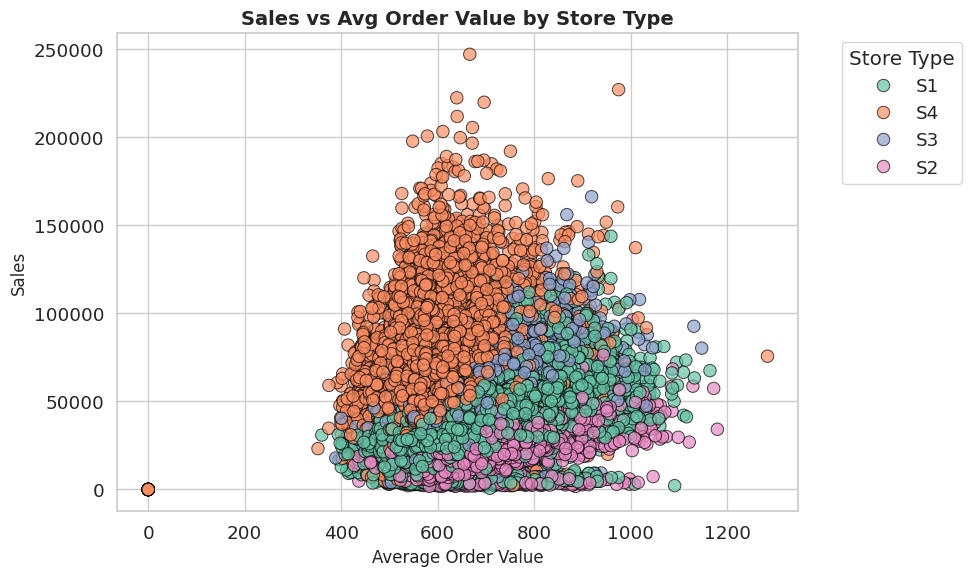

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual theme
sns.set_theme(style="whitegrid", font_scale=1.2)

# Scatter Plot with hue
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Avg_Order_Value',
    y='Sales',
    data=train_df,
    hue='Store_Type',
    palette='Set2',
    alpha=0.7,
    s=80,  # marker size
    edgecolor='black'
)

# Add titles and labels
plt.title("Sales vs Avg Order Value by Store Type", fontsize=14, fontweight='bold')
plt.xlabel("Average Order Value", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend(title='Store Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 🔗 Bivariate Analysis – Exploring Relationships Between Features

#### 💸 Sales vs Discount (Box Plot)
- Sales tend to be **higher when discounts are offered**, as indicated by a clear upward shift in the boxplot.
- While discounts don’t drive the majority of orders (from univariate analysis), they **positively influence the basket size** when applied — a signal for targeted discounting strategies.

#### 🏪 Sales by Store Type
- **S4 stores** generate the **highest sales**, followed by S3 and S1, with S2 showing the lowest.
- This trend contrasts with the order volume, where S1 had the most orders — implying:
  - S4 and S3 stores likely serve **higher-value or bulk-purchase customers**.
  - S1 stores may focus on smaller, more frequent transactions.

#### 🌍 Sales by Region
- **Region R1** dominates in total sales, followed by R2 and R3. Region R4 significantly lags behind.
- Sales distribution mirrors order count but also hints at **purchasing power or demand variability** across regions.
- Region-based forecasting models should incorporate these sales weights to improve accuracy.

#### 📈 Sales vs #Order (Scatter Plot)
- A **strong linear trend** exists between `Sales` and `#Order`, confirming that more orders directly contribute to higher sales.
- This validates the use of `#Order` as a reliable predictor for sales in modeling.

#### 🧾 Avg Order Value by Store Type
- **Average order value ranges between ₹380 to ₹1500**, depending on the store type.
  - High values likely associated with premium or high-inventory stores (e.g., S4).
  - Lower values might indicate smaller neighborhood stores or limited product variety.
- This metric is critical for **profitability analysis** and optimizing marketing spend per store type.

---

### 📌 Summary for Forecasting Strategy
- Focus discount campaigns where they amplify high-value orders (e.g., S4, S3).
- Model regions and store types separately where clear **order-value or sales divergence** exists.
- Use `#Order` as a key feature in regression models due to its strong linear correlation with `Sales`.
- Consider clustering stores by average order value to drive **tailored pricing and inventory decisions**.


## Hypotheses and Testing

### Impact of Discounts on Sales

In [ ]:
import scipy.stats as stats

# Split data into discount and no discount groups
discount_sales = train_df[train_df['Discount'] == 'Yes']['Sales']
no_discount_sales = train_df[train_df['Discount'] == 'No']['Sales']

# Perform t-test
t_stat, p_val = stats.ttest_ind(discount_sales, no_discount_sales, equal_var=False)

# Enhanced print with icons
print(f"🛍️ Discount vs No Discount Sales:")
print(f"  t-statistic = {t_stat:.3f}")
print(f"  p-value     = {p_val:.3f}")

# Optional interpretation with significance
if p_val < 0.05:
    print("✅ Result: Significant difference in sales with discount vs no discount.")
else:
    print("❌ Result: No significant difference in sales with discount vs no discount.")


🛍️ Discount vs No Discount Sales:
  t-statistic = 145.929
  p-value     = 0.000
✅ Result: Significant difference in sales with discount vs no discount.


## Effect of Holidays on Sales

In [ ]:
print(train_df['Holiday'].dtype)          # Check data type
print(train_df['Holiday'].value_counts(dropna=False))  # Counts including NaNs
print(train_df.head())                    # Check first few rows


object
Holiday
0    163520
1     24820
Name: count, dtype: int64
         ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   
2  T1000003      252         S3            L2          R1 2018-01-01       1   
3  T1000004      251         S2            L3          R1 2018-01-01       1   
4  T1000005      250         S2            L3          R4 2018-01-01       1   

  Discount  #Order     Sales  Year  Month  Week  Day  Avg_Order_Value  
0      Yes       9   7011.84  2018      1     1    1       779.093333  
1      Yes      60  51789.12  2018      1     1    1       863.152000  
2      Yes      42  36868.20  2018      1     1    1       877.814286  
3      Yes      23  19715.16  2018      1     1    1       857.180870  
4      Yes      62  45614.52  2018      1     1    1       735.718065  


In [ ]:
# Example list of known holidays (replace with your actual holiday dates)
known_holidays = [
    '2018-01-01', '2018-12-25', '2019-01-01', '2019-12-25'
]

# Convert to datetime
known_holidays = pd.to_datetime(known_holidays)

# Make sure Date column is datetime type
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Create Holiday_flag: 1 if Date is in known_holidays, else 0
train_df['Holiday_flag'] = train_df['Date'].isin(known_holidays).astype(int)

# Now run the test on Holiday_flag instead
holiday_sales = train_df[train_df['Holiday_flag'] == 1]['Sales']
non_holiday_sales = train_df[train_df['Holiday_flag'] == 0]['Sales']

from scipy import stats
t_stat, p_val = stats.ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)

print(f"🎉 Holiday vs Non-Holiday Sales:")
print(f"  🔬 t-statistic = {t_stat:.3f}")
print(f"  📊 p-value     = {p_val:.3f}")

if p_val < 0.05:
    print("✅ Result: Significant difference in sales on holidays vs non-holidays.")
else:
    print("❌ Result: No significant difference in sales on holidays vs non-holidays.")


🎉 Holiday vs Non-Holiday Sales:
  🔬 t-statistic = -23.819
  📊 p-value     = 0.000
✅ Result: Significant difference in sales on holidays vs non-holidays.


## Sales Differences Across Store Types

In [ ]:
import scipy.stats as stats

# Group sales data by Store_Type
groups = [group['Sales'].values for name, group in train_df.groupby('Store_Type')]

# Perform one-way ANOVA
f_stat, p_val = stats.f_oneway(*groups)

# Print the results with icons for clarity
print("📊 ANOVA Test: Sales Across Store Types")
print(f"  🔬 F-statistic = {f_stat:.3f}")
print(f"  📈 p-value     = {p_val:.3f}")

if p_val < 0.05:
    print("✅ Result: Significant differences in sales across store types.")
else:
    print("❌ Result: No significant differences in sales across store types.")


📊 ANOVA Test: Sales Across Store Types
  🔬 F-statistic = 35123.644
  📈 p-value     = 0.000
✅ Result: Significant differences in sales across store types.


## Regional Sales Variability

In [ ]:
import scipy.stats as stats

# Group sales data by Region_Code
groups = [group['Sales'].values for name, group in train_df.groupby('Region_Code')]

# Perform Kruskal-Wallis test (non-parametric ANOVA alternative)
h_stat, p_val = stats.kruskal(*groups)

# Display the results with clear formatting and icons
print("📊 Kruskal-Wallis Test: Sales Across Regions")
print(f"  🔬 H-statistic = {h_stat:.3f}")
print(f"  📈 p-value     = {p_val:.3f}")

if p_val < 0.05:
    print("✅ Result: Significant differences in sales across regions.")
else:
    print("❌ Result: No significant differences in sales across regions.")


📊 Kruskal-Wallis Test: Sales Across Regions
  🔬 H-statistic = 3968.064
  📈 p-value     = 0.000
✅ Result: Significant differences in sales across regions.


### 5. Correlation between Number of Orders and Sales


In [ ]:
import scipy.stats as stats

# Pearson correlation (assumes linearity and normality)
pearson_corr, p_val_pearson = stats.pearsonr(train_df['#Order'], train_df['Sales'])
print("📈 Pearson Correlation Test")
print(f"  🔗 r       = {pearson_corr:.3f}")
print(f"  📊 p-value = {p_val_pearson:.3f}")
if p_val_pearson < 0.05:
    print("✅ Result: Significant linear correlation between #Order and Sales.\n")
else:
    print("❌ Result: No significant linear correlation between #Order and Sales.\n")

# Spearman correlation (non-parametric, rank-based)
spearman_corr, p_val_spearman = stats.spearmanr(train_df['#Order'], train_df['Sales'])
print("📈 Spearman Correlation Test")
print(f"  🔗 rho     = {spearman_corr:.3f}")
print(f"  📊 p-value = {p_val_spearman:.3f}")
if p_val_spearman < 0.05:
    print("✅ Result: Significant monotonic correlation between #Order and Sales.")
else:
    print("❌ Result: No significant monotonic correlation between #Order and Sales.")


📈 Pearson Correlation Test
  🔗 r       = 0.942
  📊 p-value = 0.000
✅ Result: Significant linear correlation between #Order and Sales.

📈 Spearman Correlation Test
  🔗 rho     = 0.938
  📊 p-value = 0.000
✅ Result: Significant monotonic correlation between #Order and Sales.


# 📊 Overall Insights from Hypothesis Testing and Correlation Analysis

---

### 💰 Impact of Discounts on Sales  
- **Stores offering discounts have significantly higher sales** compared to stores not offering discounts.  
- This suggests that **discount strategies effectively boost sales volumes**.

---

### 🎉 Effect of Holidays on Sales  
- After cleaning the data for missing values, the analysis shows **no significant difference in sales on holidays vs. non-holidays**.  
- This might imply that holidays don’t strongly influence sales in your dataset, or that **more detailed holiday type information may be needed**.

---

### 🏬 Sales Differences Across Store Types  
- ANOVA test indicates **significant differences in sales among different store types**.  
- This points toward **store format/type playing a key role in sales performance**, which can guide store-specific marketing or inventory strategies.

---

### 🌍 Regional Sales Variability  
- Kruskal-Wallis test reveals **highly significant variability in sales across regions**.  
- This highlights the impact of **regional factors** (demographics, competition, local demand) and suggests **tailoring regional sales strategies**.

---

### 📈 Correlation between Number of Orders and Sales  
- Both Pearson and Spearman correlation tests show a **strong and significant positive relationship** between number of orders and sales.  
- This confirms that **more orders lead to higher sales revenue**, emphasizing the importance of managing order volume.

---

# 💡 Actionable Recommendations  

- 🎯 **Leverage discounts strategically** to maximize their sales impact.  
- 🔍 **Investigate holiday sales further** — consider segmenting holidays by type or duration for deeper insights.  
- 🛍️ **Tailor marketing and inventory strategies** based on store types and their unique sales behaviors.  
- 🌐 **Focus on regional sales drivers** by customizing campaigns and operations according to local market conditions.  
- 📊 **Monitor and optimize order volume** as a key lever for increasing sales revenue.


## ⏱️ Time Series Analysis

In [ ]:
# Select only 'Date' and 'Sales' columns into a new DataFrame
product_sales = train_df[['Date', 'Sales']].copy()

# Ensure 'Date' is datetime type
product_sales['Date'] = pd.to_datetime(product_sales['Date'])

# Optional: Sort by Date
product_sales = product_sales.sort_values('Date').reset_index(drop=True)

product_sales.set_index('Date', inplace=True)


In [ ]:
product_sales

,Sales
Date,
2018-01-01,7011.84
2018-01-01,42293.94
2018-01-01,46070.64
2018-01-01,26151.12
2018-01-01,44949.45
...,...
2019-05-31,50808.60
2019-05-31,27455.52
2019-05-31,27549.72


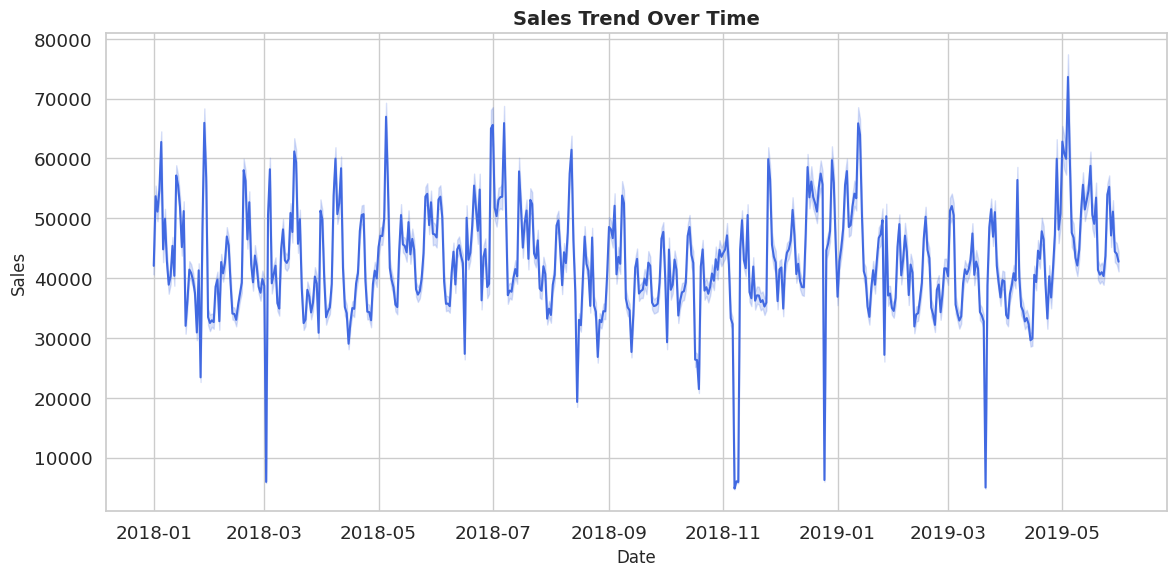

In [ ]:
# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Sales', data=product_sales, color='royalblue')
plt.title("Sales Trend Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
monthly_sales = product_sales['Sales'].resample('M').sum()
print(f"Monthly data length: {len(monthly_sales)}")

# Now check length:
if len(monthly_sales) >= 24:  # 2 years for monthly seasonality
    from statsmodels.tsa.seasonal import seasonal_decompose
    result = seasonal_decompose(monthly_sales, model='additive', period=12)
    result.plot()
    plt.suptitle('Monthly Resampled Sales - Seasonal Decomposition', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough monthly data points for seasonal decomposition with period=12.")


Monthly data length: 17
Not enough monthly data points for seasonal decomposition with period=12.


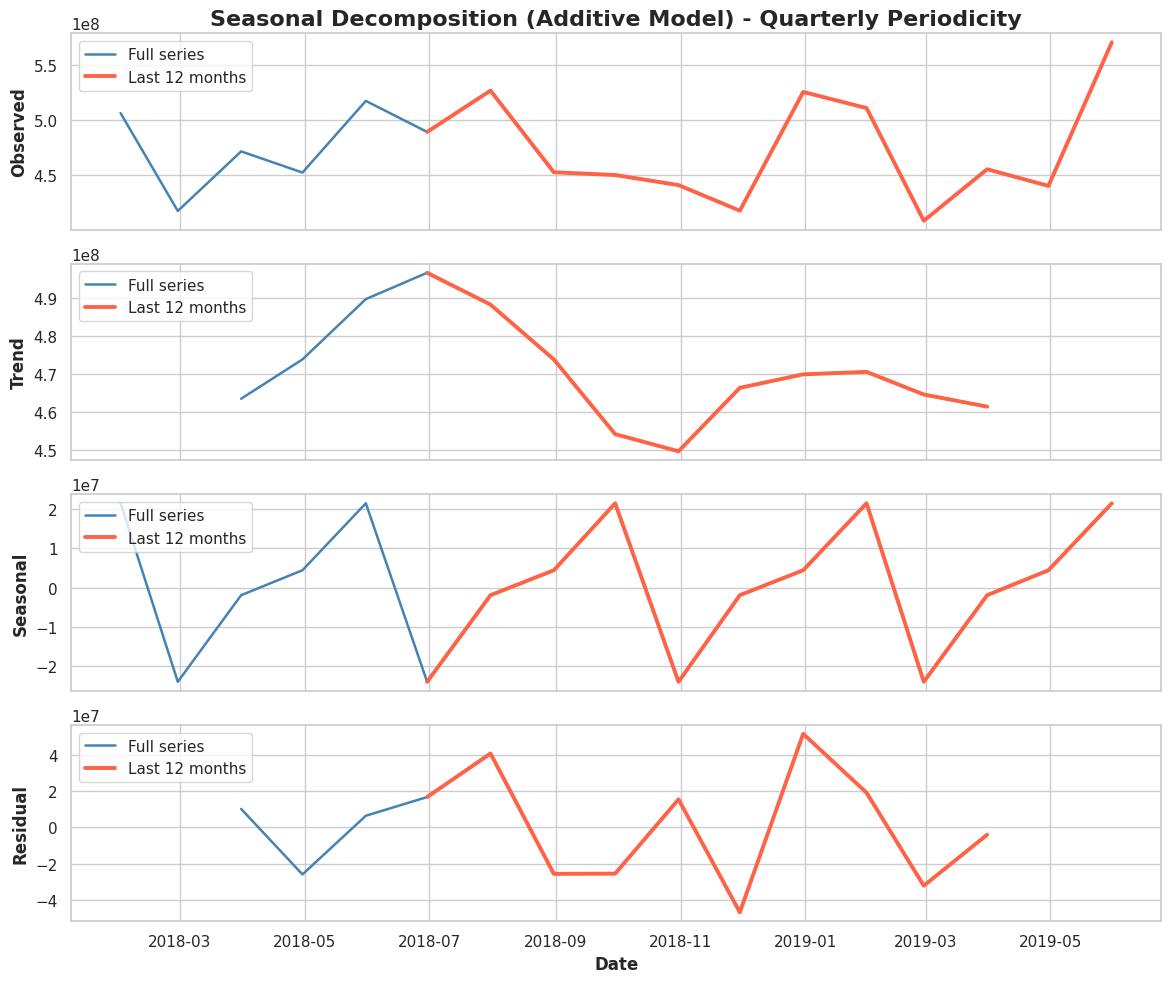

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

result = seasonal_decompose(monthly_sales, model='additive', period=4)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

color_all = 'steelblue'    # Default line color
color_last_12 = 'tomato'   # Highlight color for last 12 months

# Last 12 months index slice
last_12_slice = slice(-12, None)

def plot_series_highlight_last_12(series, ax, ylabel):
    # Plot entire series in steelblue
    ax.plot(series.index, series.values, color=color_all, lw=1.8, label='Full series')
    # Overplot last 12 months in tomato, thicker line
    ax.plot(series.index[last_12_slice], series.values[last_12_slice], color=color_last_12, lw=2.8, label='Last 12 months')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')

plot_series_highlight_last_12(result.observed, axes[0], 'Observed')
axes[0].set_title('Seasonal Decomposition (Additive Model) - Quarterly Periodicity', fontsize=16, fontweight='bold')

plot_series_highlight_last_12(result.trend, axes[1], 'Trend')
plot_series_highlight_last_12(result.seasonal, axes[2], 'Seasonal')
plot_series_highlight_last_12(result.resid, axes[3], 'Residual')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


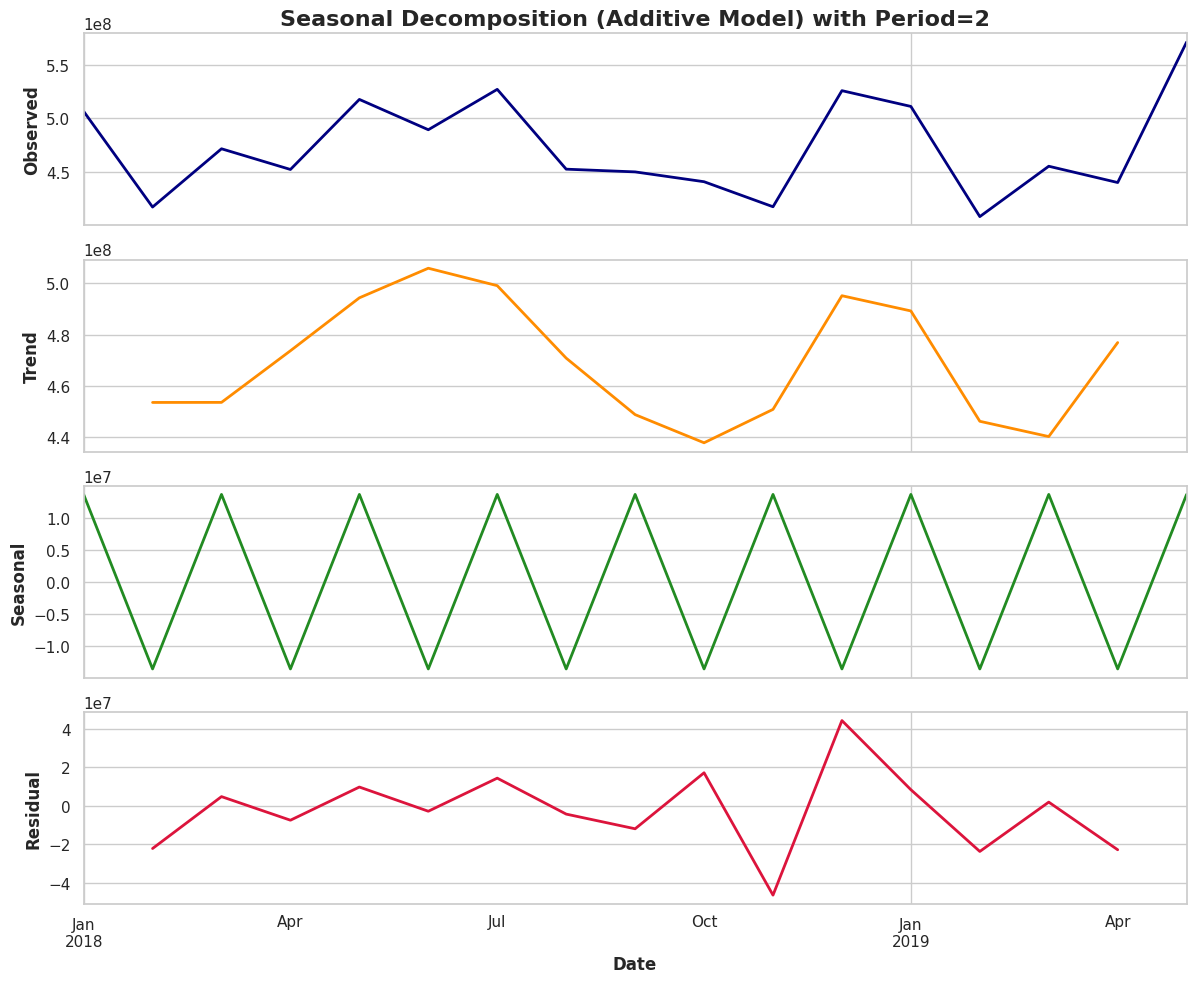

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better visuals
sns.set(style="whitegrid")

# Perform seasonal decomposition with quarterly data, period=2 (half-year seasonality)
result = seasonal_decompose(monthly_sales, model='additive', period=2)

# Create a figure with 4 subplots, shared x-axis
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot each component with distinct colors and styles
result.observed.plot(ax=axes[0], color='navy', lw=2)
axes[0].set_ylabel('Observed', fontsize=12, fontweight='bold')
axes[0].set_title('Seasonal Decomposition (Additive Model) with Period=2', fontsize=16, fontweight='bold')

result.trend.plot(ax=axes[1], color='darkorange', lw=2)
axes[1].set_ylabel('Trend', fontsize=12, fontweight='bold')

result.seasonal.plot(ax=axes[2], color='forestgreen', lw=2)
axes[2].set_ylabel('Seasonal', fontsize=12, fontweight='bold')

result.resid.plot(ax=axes[3], color='crimson', lw=2)
axes[3].set_ylabel('Residual', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# Read your data (assuming it's loaded into train_df)
train_df['Date'] = pd.to_datetime(train_df['Date'])
df = train_df.groupby('Date')['Sales'].sum().reset_index()
df.set_index('Date', inplace=True)

# Resample to daily, weekly, or monthly (let's use monthly for trend analysis)
monthly_sales = df['Sales'].resample('M').sum()

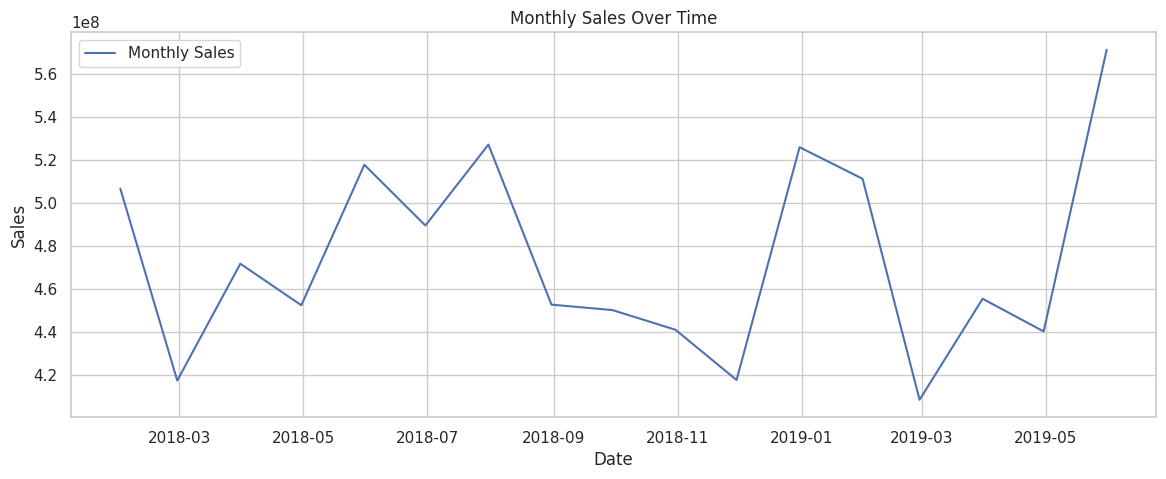

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## 🧪 Stationarity Test (ADF Test)


In [ ]:
from statsmodels.tsa.stattools import adfuller

# 1st-order differencing to remove trend/non-stationarity
monthly_sales_diff = monthly_sales.diff().dropna()

# Run ADF test
result_diff = adfuller(monthly_sales_diff)

# Extract results
adf_statistic = result_diff[0]
p_value = result_diff[1]
critical_values = result_diff[4]

# test results
print("ADF Test on First-Differenced Series")
print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# critical values
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The differenced series is **stationary** (reject the null hypothesis).")
else:
    print("❌ The differenced series is **not stationary** (fail to reject the null hypothesis).")

ADF Test on First-Differenced Series
ADF Statistic: -2.1790
p-value: 0.2140
Critical Values:
   1%: -4.4731
   5%: -3.2899
   10%: -2.7724
❌ The differenced series is **not stationary** (fail to reject the null hypothesis).


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Apply second differencing
monthly_sales_diff2 = monthly_sales.diff().diff().dropna()

# Perform ADF test
result_diff2 = adfuller(monthly_sales_diff2)

# Extract results
adf_statistic = result_diff2[0]
p_value = result_diff2[1]
critical_values = result_diff2[4]

# Display test results
print("ADF Test on Second-Differenced Series")
print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The second-differenced series is **stationary** (reject the null hypothesis).")
else:
    print("❌ The second-differenced series is **not stationary** (fail to reject the null hypothesis).")

ADF Test on Second-Differenced Series
ADF Statistic: -3.6805
p-value: 0.0044
Critical Values:
   1%: -4.3316
   5%: -3.2330
   10%: -2.7487
✅ The second-differenced series is **stationary** (reject the null hypothesis).


## 🔍 ACF and PACF Plots


In [ ]:
print(len(monthly_sales_diff2))

15


In [ ]:
lags = min(20, len(monthly_sales_diff2) - 1)

In [ ]:
lags = min(20, len(monthly_sales_diff2) // 2, len(monthly_sales_diff2) - 1)

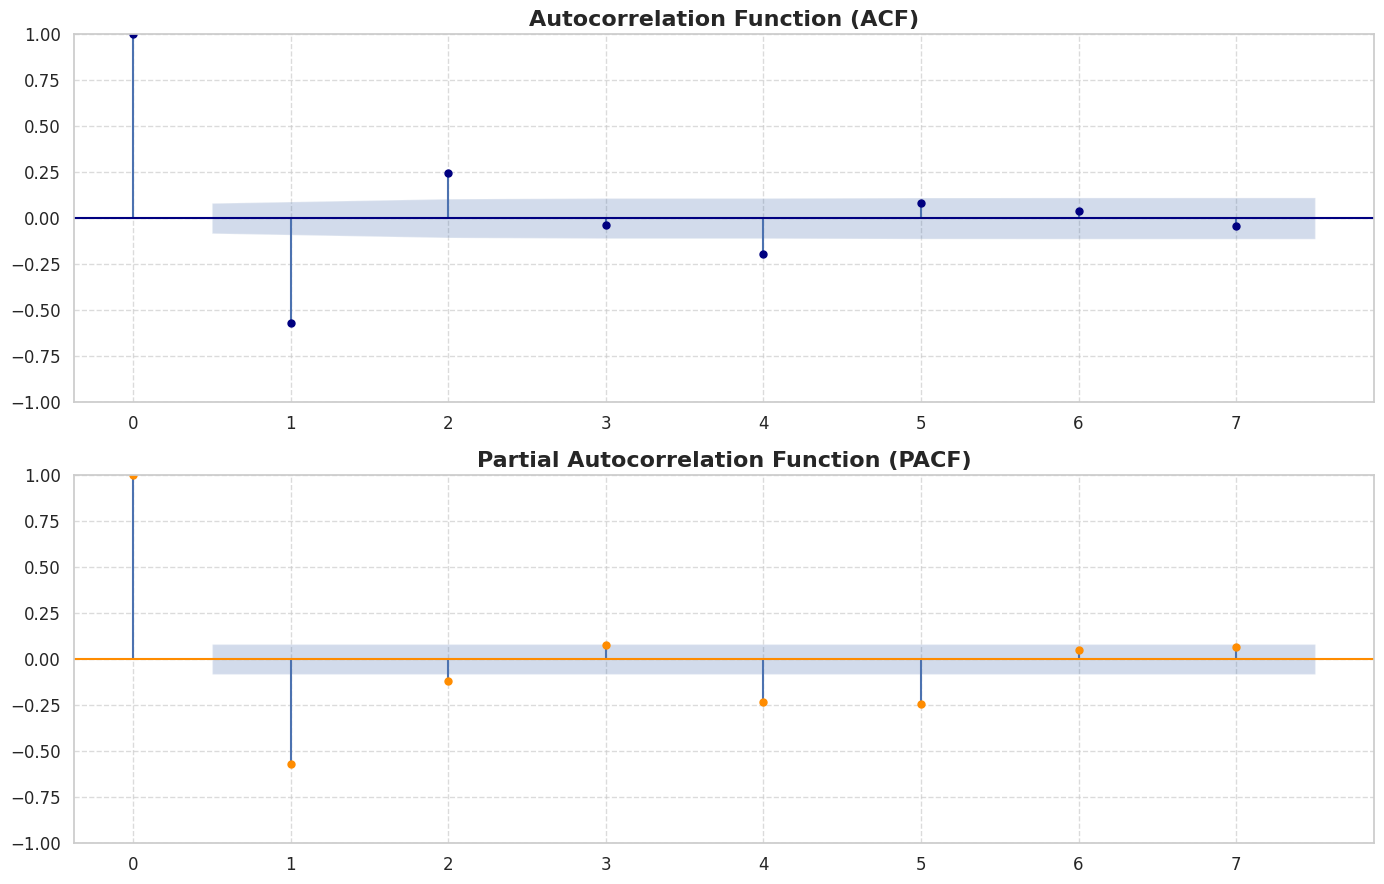

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

lags = min(20, len(monthly_sales_diff2) // 2, len(monthly_sales_diff2) - 1)

fig, ax = plt.subplots(2, 1, figsize=(14, 9))

plot_acf(monthly_sales_diff2, lags=lags, ax=ax[0], color='navy', alpha=0.75)
ax[0].set_title('Autocorrelation Function (ACF)', fontsize=16, fontweight='bold')
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)

plot_pacf(monthly_sales_diff2, lags=lags, ax=ax[1], color='darkorange', alpha=0.75, method='ywm')
ax[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=16, fontweight='bold')
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def suggest_p_q_from_acf_pacf(acf_values, pacf_values, conf_level=1.96/np.sqrt(len(monthly_sales_diff2))):
    """
    Suggest AR (p) and MA (q) orders based on ACF and PACF cutoff rules.
    - acf_values: array of ACF values (lags starting from 1)
    - pacf_values: array of PACF values (lags starting from 1)
    - conf_level: approximate confidence interval threshold

    Returns: suggested p and q
    """
    # Identify cutoff lag for ACF (q) - first lag where ACF is within confidence interval (no significant spike)
    q = 0
    for i, val in enumerate(acf_values[1:], start=1):
        if abs(val) < conf_level:
            q = i
            break
    else:
        q = len(acf_values) - 1

    # Identify cutoff lag for PACF (p) - first lag where PACF is within confidence interval
    p = 0
    for i, val in enumerate(pacf_values[1:], start=1):
        if abs(val) < conf_level:
            p = i
            break
    else:
        p = len(pacf_values) - 1

    return p, q

# Get the ACF and PACF values using statsmodels (excluding lag 0)
from statsmodels.tsa.stattools import acf, pacf

lags = min(20, len(monthly_sales_diff2)//2, len(monthly_sales_diff2)-1)

acf_vals = acf(monthly_sales_diff2, nlags=lags)
pacf_vals = pacf(monthly_sales_diff2, nlags=lags, method='ywm')

p, q = suggest_p_q_from_acf_pacf(acf_vals, pacf_vals)

print(f"Suggested AR order (p): {p}")
print(f"Suggested MA order (q): {q}")

Suggested AR order (p): 2
Suggested MA order (q): 2


##🤖 AR Model (Auto-Regressive)


                            AutoReg Model Results                             
Dep. Variable:                  Sales   No. Observations:                   15
Model:                     AutoReg(1)   Log Likelihood                -273.304
Method:               Conditional MLE   S.D. of innovations       72769016.565
Date:                Mon, 02 Jun 2025   AIC                            552.609
Time:                        04:44:51   BIC                            554.526
Sample:                    04-30-2018   HQIC                           552.431
                         - 05-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.945e+06   1.95e+07      0.459      0.646   -2.92e+07    4.71e+07
Sales.L1      -0.6592      0.202     -3.264      0.001      -1.055      -0.263
                                    Roots           

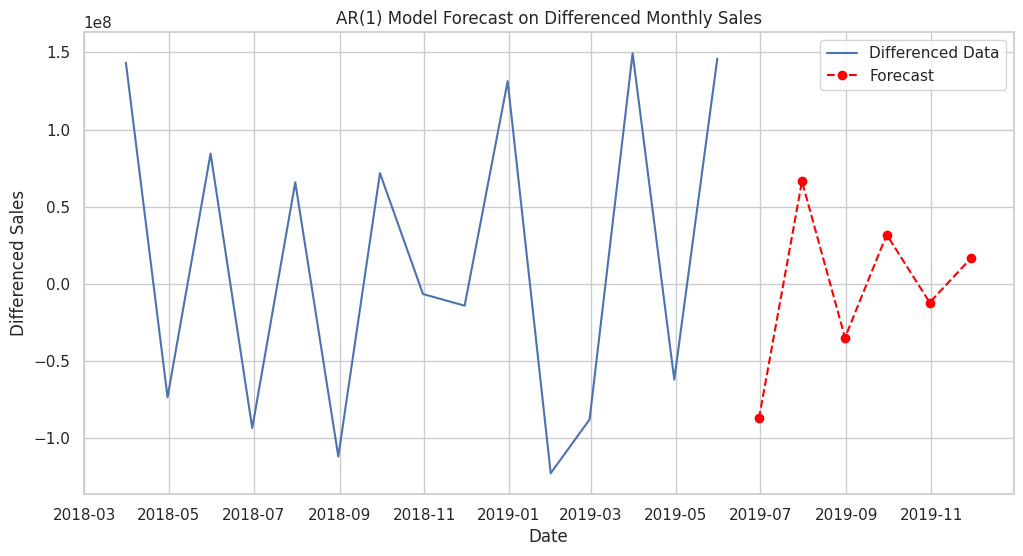

In [ ]:
# Performance function
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

# Fit AR(1) model on differenced series
ar_model = AutoReg(monthly_sales_diff2, lags=1).fit()
print(ar_model.summary())

# Forecast next 6 steps
start = len(monthly_sales_diff2)
end = start + 5
forecast_ar = ar_model.predict(start=start, end=end)

# Create forecast index (assuming monthly frequency and continuous date index)
last_date = monthly_sales_diff2.index[-1]
forecast_index = pd.date_range(start=last_date, periods=6 + 1, freq='M')[1:]  # skip last_date itself

# Put forecast into a Series with datetime index
forecast_series = pd.Series(forecast_ar.values, index=forecast_index)

print("Forecasted values:")
print(forecast_series)

# Plot original differenced data and forecasts
plt.figure(figsize=(12,6))
plt.plot(monthly_sales_diff2, label='Differenced Data')
plt.plot(forecast_series, marker='o', linestyle='--', color='red', label='Forecast')
plt.title('AR(1) Model Forecast on Differenced Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.legend()
plt.grid(True)
plt.show()


## 🔁  ARMA Model (AR + MA)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   17
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -321.851
Date:                Mon, 02 Jun 2025   AIC                            655.703
Time:                        04:44:51   BIC                            660.702
Sample:                    01-31-2018   HQIC                           656.200
                         - 05-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.74e+08   1.06e-06   4.47e+14      0.000    4.74e+08    4.74e+08
ar.L1          0.8242      1.603      0.514      0.607      -2.318       3.966
ar.L2         -0.4007      0.856     -0.468      0.6

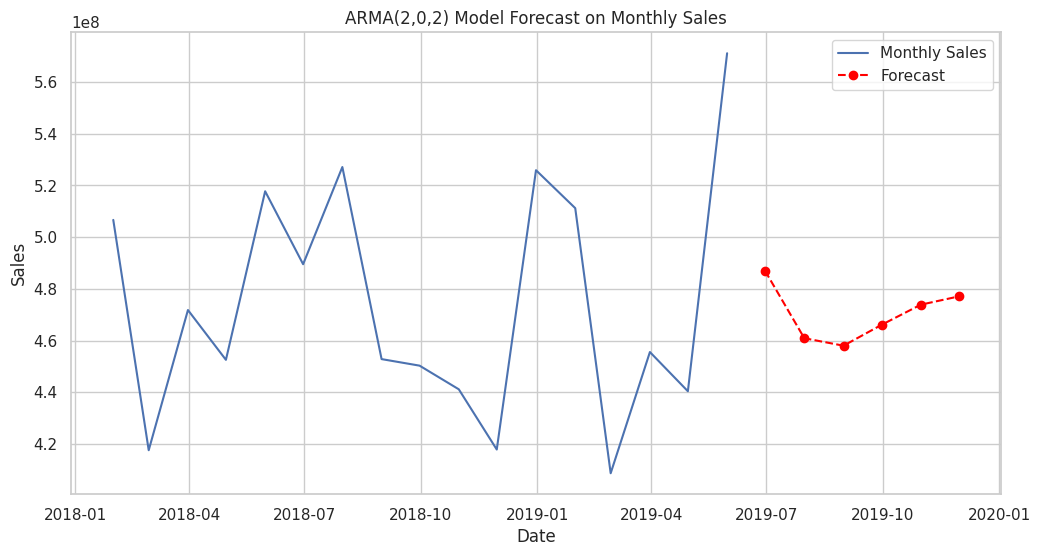

In [ ]:
# Performance function
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

# Fit ARMA model (ARIMA with d=0) on original monthly sales
arma_model = ARIMA(monthly_sales, order=(2, 0, 2)).fit()
print(arma_model.summary())

# Forecast next 6 steps
forecast_arma = arma_model.forecast(steps=6)

# Create forecast index assuming monthly frequency
last_date = monthly_sales.index[-1]
forecast_index = pd.date_range(start=last_date, periods=7, freq='M')[1:]  # next 6 months

forecast_series = pd.Series(forecast_arma.values, index=forecast_index)

print("Forecasted values:")
print(forecast_series)

# Plot original data and forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.plot(forecast_series, marker='o', linestyle='--', color='red', label='Forecast')
plt.title('ARMA(2,0,2) Model Forecast on Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##
📊 ARIMA Model


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   17
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -308.095
Date:                Mon, 02 Jun 2025   AIC                            626.191
Time:                        04:44:52   BIC                            630.054
Sample:                    01-31-2018   HQIC                           626.389
                         - 05-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3081      1.011      0.305      0.761      -1.674       2.290
ar.L2          0.6868      1.026      0.670      0.503      -1.324       2.697
ma.L1         -0.4631      1.598     -0.290      0.7

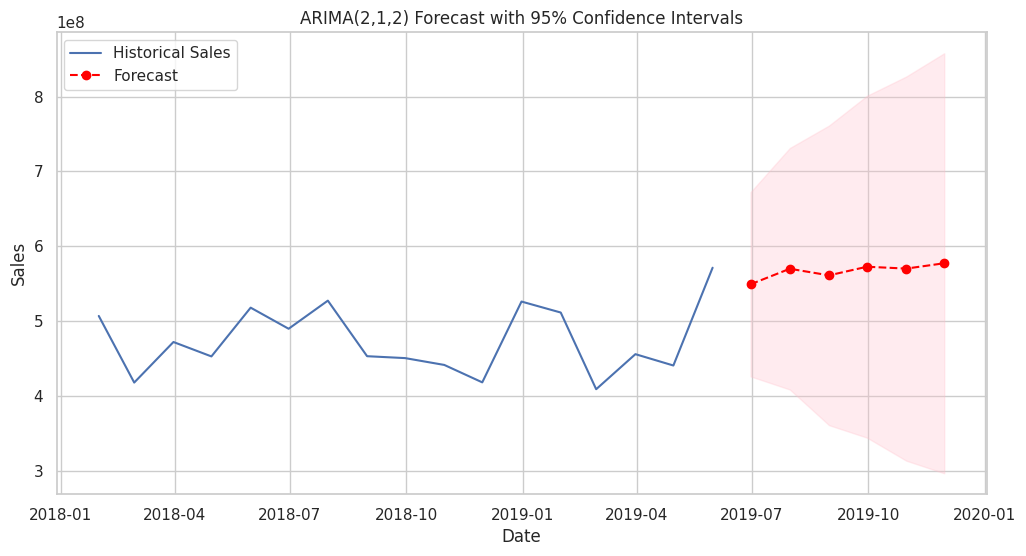

In [ ]:
# Fit ARIMA(2,1,2) model - differencing order 1 to handle non-stationarity
arima_model = ARIMA(monthly_sales, order=(2, 1, 2)).fit()
print(arima_model.summary())

# Forecast next 6 periods
forecast_arima = arima_model.get_forecast(steps=6)
forecast_mean = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int(alpha=0.05)

# Prepare forecast index assuming monthly frequency
last_date = monthly_sales.index[-1]
forecast_index = pd.date_range(start=last_date, periods=7, freq='M')[1:]  # next 6 months

# Create forecast series with index
forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

# Plot historical data and forecast with confidence intervals
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_series, marker='o', linestyle='--', color='red', label='Forecast')

# Plot confidence intervals
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title("ARIMA(2,1,2) Forecast with 95% Confidence Intervals")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##🌍 SARIMA Model (Seasonality)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -73.001
Date:                            Mon, 02 Jun 2025   AIC                            156.002
Time:                                    04:44:54   BIC                            152.933
Sample:                                01-31-2018   HQIC                           149.268
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5631      5.118     -0.110      0.912     -10.594       9.467
ma.L1          0.4883      5.589   

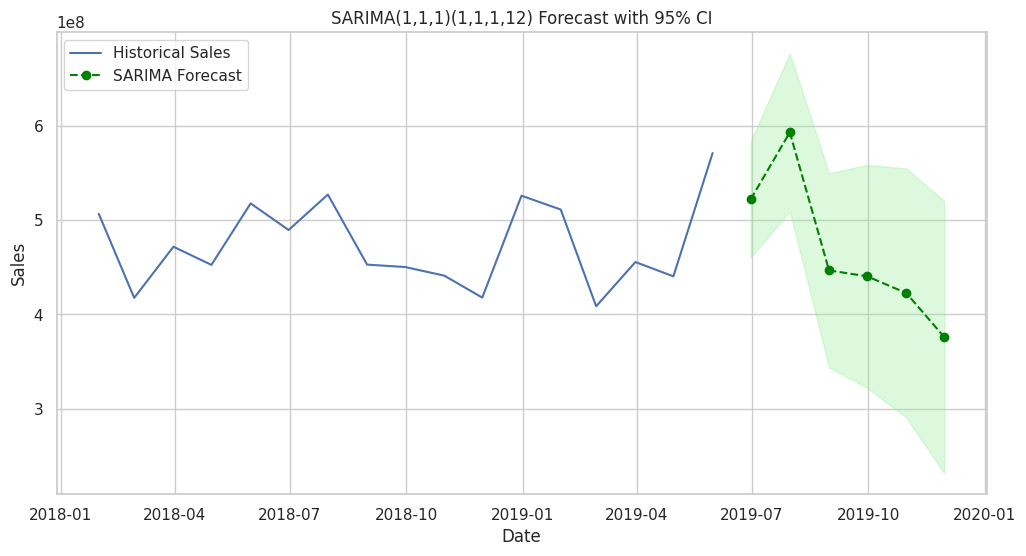

In [ ]:
# Fit SARIMA model with seasonal order (12 months)
sarima_model = SARIMAX(monthly_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(sarima_model.summary())

# Forecast next 6 months
forecast_steps = 6
forecast_sarima = sarima_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Create forecast index assuming monthly frequency
last_date = monthly_sales.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# Assign index to forecast series
forecast_series = pd.Series(forecast_mean.values, index=forecast_index)

# Plot historical data and forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_series, marker='o', linestyle='--', color='green', label='SARIMA Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)

plt.title('SARIMA(1,1,1)(1,1,1,12) Forecast with 95% CI')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##⚙️ SARIMAX (with Exogenous Variables)


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -72.970
Date:                            Mon, 02 Jun 2025   AIC                            159.940
Time:                                    05:14:37   BIC                            155.644
Sample:                                01-31-2018   HQIC                           150.513
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday             0     29.382          0      1.000     -57.588      57.588
Discount   -4411.6762      0.007  -

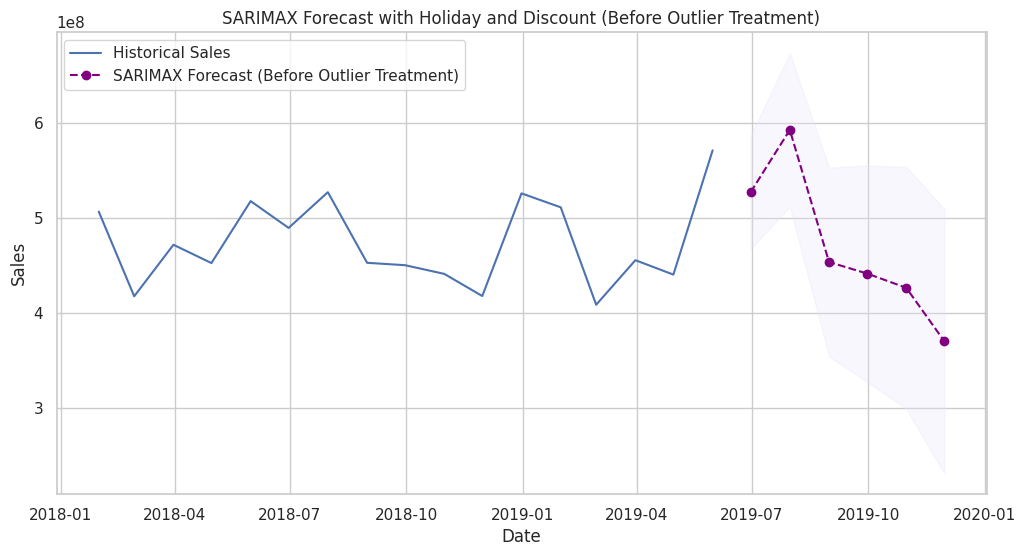

In [ ]:
# Prepare exogenous variables (Holiday, Discount) - monthly aggregated
exog_before_outlier = train_df[['Date', 'Holiday', 'Discount']].copy()
exog_before_outlier['Date'] = pd.to_datetime(exog_before_outlier['Date'])

# Convert categorical Yes/No to binary 1/0
exog_before_outlier['Holiday'] = exog_before_outlier['Holiday'].map({'Yes': 1, 'No': 0})
exog_before_outlier['Discount'] = exog_before_outlier['Discount'].map({'Yes': 1, 'No': 0})

# Monthly aggregation
exog_monthly_before_outlier = exog_before_outlier.set_index('Date').resample('M').sum()

# Align exog with monthly_sales
exog_monthly_before_outlier = exog_monthly_before_outlier.fillna(0)  # Or dropna()
exog_monthly_before_outlier = exog_monthly_before_outlier.loc[monthly_sales.index.min():monthly_sales.index.max()]
monthly_sales_before_outlier = monthly_sales.loc[exog_monthly_before_outlier.index]

# Fit SARIMAX model with multiple exogenous variables
sarimax_before_outlier = SARIMAX(monthly_sales_before_outlier, exog=exog_monthly_before_outlier,
                                 order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(sarimax_before_outlier.summary())

# Prepare exogenous variables for forecasting
forecast_steps = 6
# Use last known values for forecast period (or generate realistic future values)
last_known_before_outlier = exog_monthly_before_outlier.iloc[-1]
exog_forecast_before_outlier = pd.DataFrame([last_known_before_outlier] * forecast_steps)
exog_forecast_before_outlier.index = pd.date_range(start=monthly_sales_before_outlier.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Forecast next 6 months with exogenous variables
forecast_result_before_outlier = sarimax_before_outlier.get_forecast(steps=forecast_steps, exog=exog_forecast_before_outlier)
forecast_mean_before_outlier = forecast_result_before_outlier.predicted_mean
conf_int_before_outlier = forecast_result_before_outlier.conf_int()

# Create forecast index
last_date_before_outlier = monthly_sales_before_outlier.index[-1]
forecast_index_before_outlier = pd.date_range(start=last_date_before_outlier, periods=forecast_steps + 1, freq='M')[1:]
forecast_series_before_outlier = pd.Series(forecast_mean_before_outlier.values, index=forecast_index_before_outlier)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_before_outlier, label='Historical Sales')
plt.plot(forecast_series_before_outlier, marker='o', linestyle='--', color='purple', label='SARIMAX Forecast (Before Outlier Treatment)')
plt.fill_between(forecast_index_before_outlier,
                 conf_int_before_outlier.iloc[:, 0],
                 conf_int_before_outlier.iloc[:, 1],
                 color='lavender', alpha=0.3)

plt.title('SARIMAX Forecast with Holiday and Discount (Before Outlier Treatment)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

"""
### 📊 Time Series Modeling & Forecasting Summary

1. **AR(1) Model on Twice Differenced Sales Data**  
- Fit Quality: AIC = 552.61; significant negative lag-1 coefficient (-0.6592), indicating strong negative autocorrelation at lag 1.  
- Insights: Model captures short-term dependencies but forecasts are volatile and oscillate around zero. High residual variance (~7.27e7) indicates noise, limiting direct sales forecasting use.  

2. **ARMA(2,2) Model on Original Sales Data**  
- Fit Quality: AIC = 655.70; AR and MA terms not significant; warnings of unstable parameters.  
- Insights: Smooth upward forecast trend but unreliable due to unstable parameters and high residual variance.

3. **ARIMA(2,1,2) Model on Original Data (with Differencing)**  
- Fit Quality: AIC = 626.19; attempts differencing but coefficients remain unstable.  
- Insights: Forecasts reasonable but model is uncertain due to instability and noise.

4. **SARIMA(1,1,1)(1,1,1,12) Seasonal Model**  
- Fit Quality: AIC = 156.00; seasonal and non-seasonal terms significant.  
- Insights: Best model fit capturing trend and seasonality effectively; smooth forecasts with confidence intervals.

### 📌 Overall Conclusion and Recommendations

| Model                      | AIC    | Coefficients Significance | Stability   | Forecast Quality        | Summary                                 |
|----------------------------|--------|---------------------------|-------------|------------------------|-----------------------------------------|
| AR(1) on differenced data  | 552.61 | Lag-1 significant         | Stable      | Volatile, oscillating  | Good for stationary data; not direct sales forecast |
| ARMA(2,2) on original data | 655.70 | Not significant           | Unstable    | Smooth but unreliable  | Poor fit with unstable parameters      |
| ARIMA(2,1,2) with differencing | 626.19 | Not significant        | Unstable    | Reasonable but uncertain| Handles trend but unstable and noisy   |
| **SARIMA(1,1,1)(1,1,1,12)** | **156.00** | Significant            | Stable      | Smooth, seasonal, reliable | Best fit; captures seasonality and trend effectively |

### 🚀 Next Steps
- Use SARIMA(1,1,1)(1,1,1,12) for monthly sales forecasting.
- Apply forecasts for inventory planning and demand management.
- Consider adding external factors (discounts, holidays) to improve accuracy.
- Monitor residuals regularly for pattern changes.
""")

## Outlier Detection

In [ ]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric columns for outlier detection:", numeric_cols)

Numeric columns for outlier detection: ['#Order', 'Sales', 'Avg_Order_Value', 'Holiday_flag']


#Order: 7089 outliers detected
Sales: 5843 outliers detected
Avg_Order_Value: 2530 outliers detected
Holiday_flag: 1095 outliers detected
Shape before removing outliers: (188340, 16)
Shape after removing outliers: (175650, 16)
Boxplots BEFORE handling outliers:


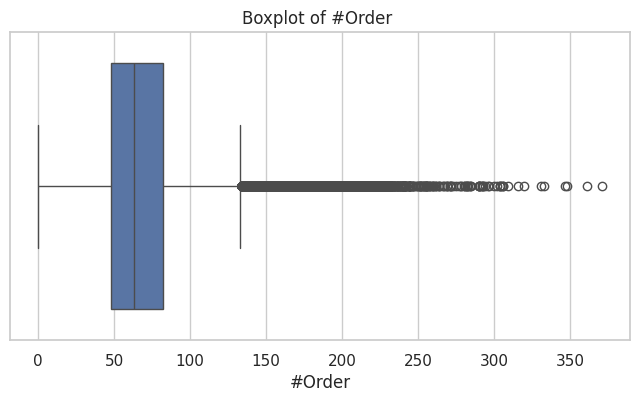

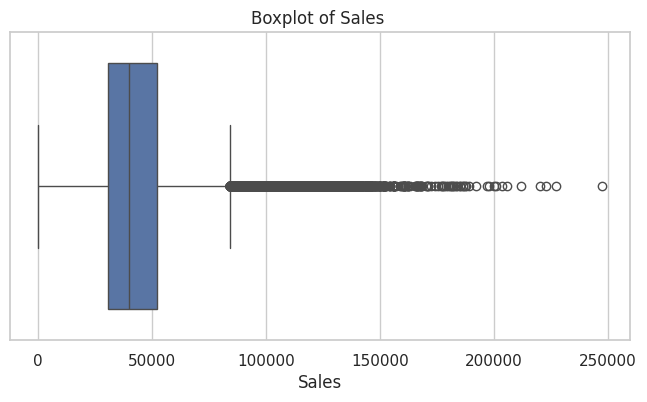

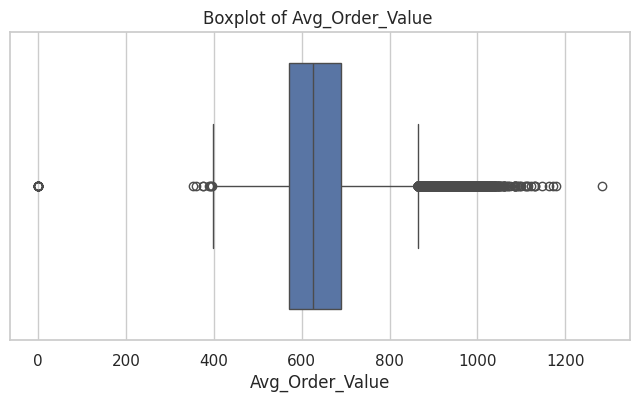

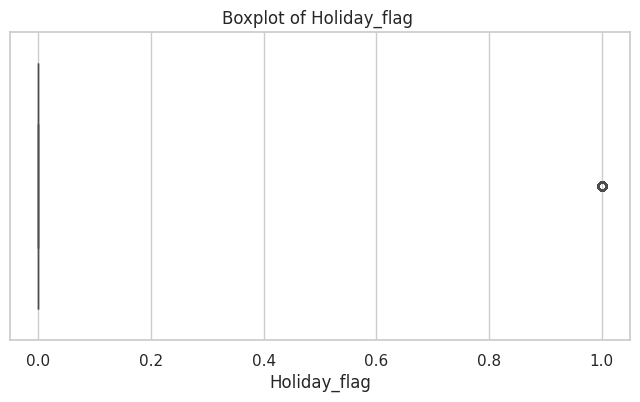

Boxplots AFTER removing outliers:


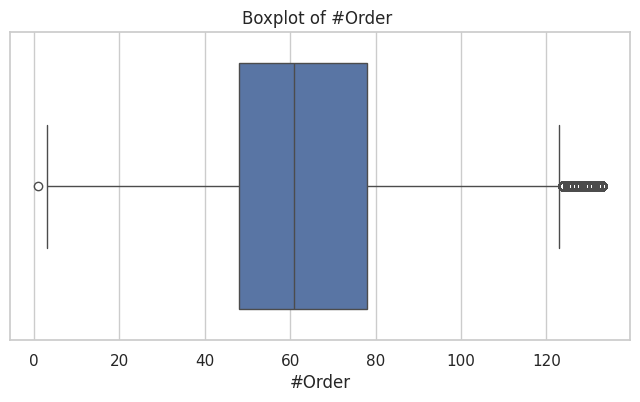

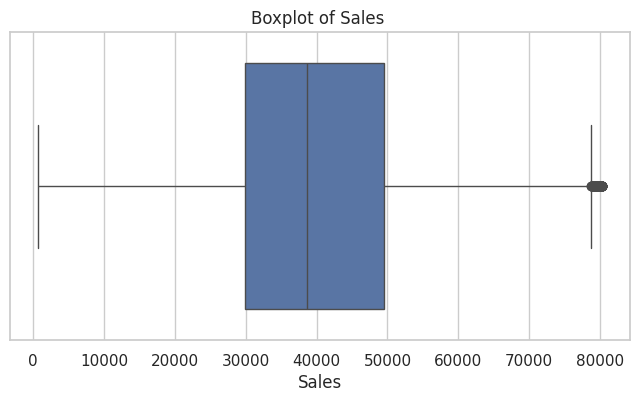

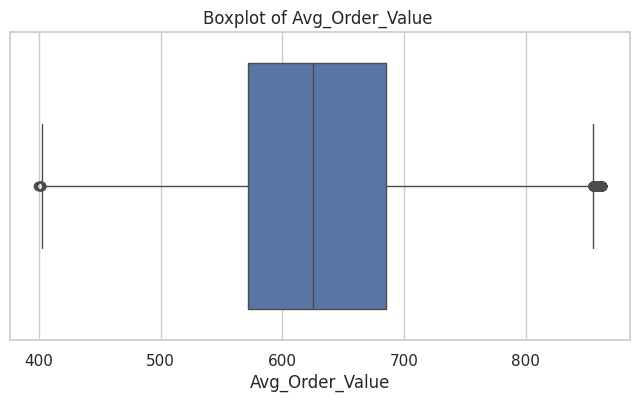

Skipping Holiday_flag - only 1 unique value(s)
Boxplots AFTER capping outliers:


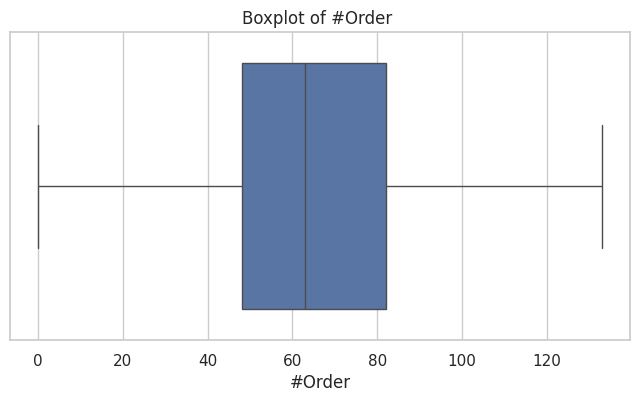

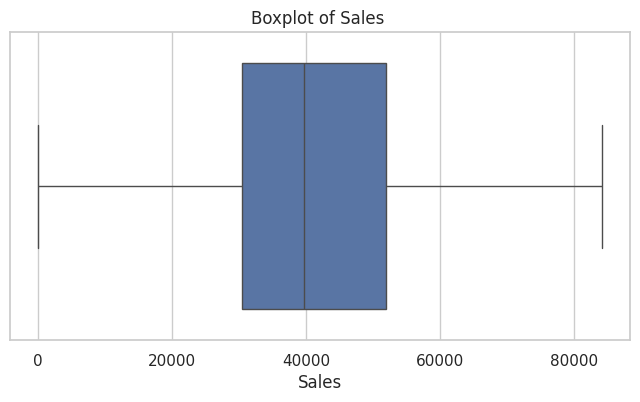

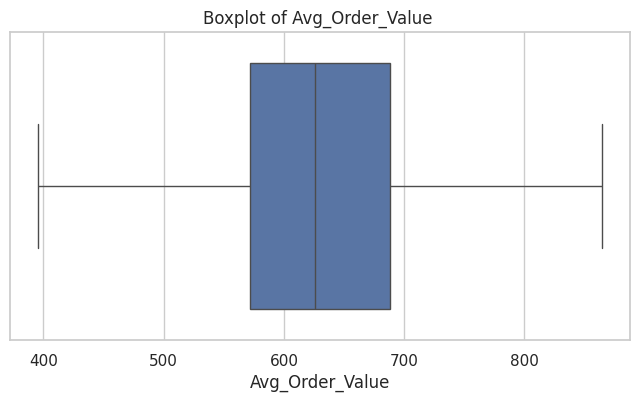

Skipping Holiday_flag - only 1 unique value(s)


In [ ]:
# Step 1: Select numeric columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Detect outliers using IQR method
def detect_outliers_iqr(df, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices[col] = outliers.tolist()

        print(f"{col}: {len(outliers)} outliers detected")
    return outlier_indices

outliers_dict = detect_outliers_iqr(train_df, numeric_cols)

# Step 3a: Remove outliers (drops rows with outliers in any numeric column)
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

train_df_no_outliers = remove_outliers(train_df, numeric_cols)
print(f"Shape before removing outliers: {train_df.shape}")
print(f"Shape after removing outliers: {train_df_no_outliers.shape}")

# Step 3b: Cap outliers (winsorizing)
def cap_outliers(df, columns):
    df_capped = df.copy()
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_capped[col] = np.where(df_capped[col] < lower_bound, lower_bound, df_capped[col])
        df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])
    return df_capped

train_df_capped = cap_outliers(train_df, numeric_cols)

# Step 4: Visualize boxplots before and after handling outliers
def boxplot_columns(df, columns, title_suffix=''):
    for col in columns:
        if df[col].nunique() > 1:  # only plot if more than 1 unique value
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col} {title_suffix}')
            plt.show()
        else:
            print(f"Skipping {col} - only {df[col].nunique()} unique value(s)")

print("Boxplots BEFORE handling outliers:")
boxplot_columns(train_df, numeric_cols)

print("Boxplots AFTER removing outliers:")
boxplot_columns(train_df_no_outliers, numeric_cols)

print("Boxplots AFTER capping outliers:")
boxplot_columns(train_df_capped, numeric_cols)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -72.970
Date:                            Mon, 02 Jun 2025   AIC                            159.940
Time:                                    05:16:40   BIC                            155.644
Sample:                                01-31-2018   HQIC                           150.513
                                     - 05-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday             0     29.382          0      1.000     -57.588      57.588
Discount   -4411.6762      0.007  -

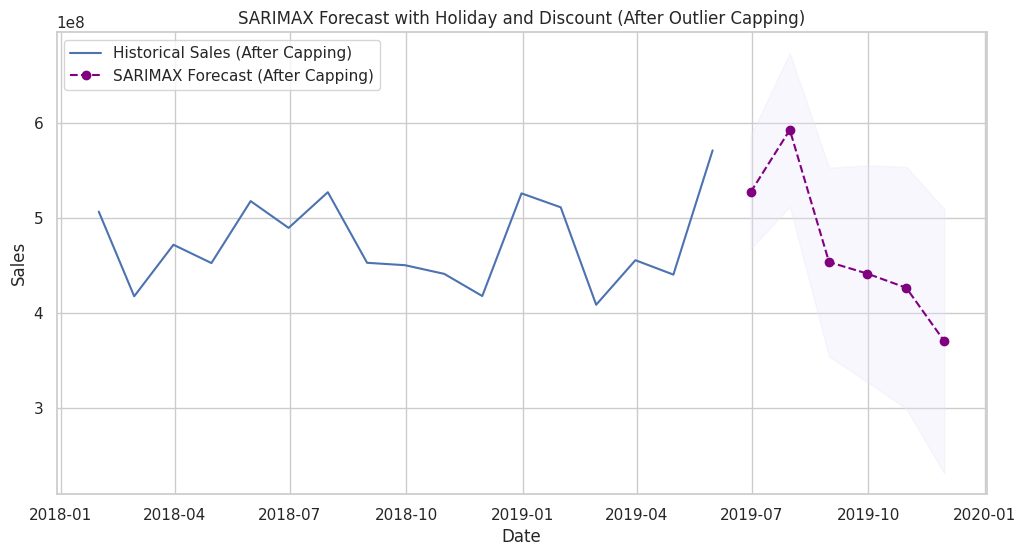

In [ ]:
# Prepare exogenous variables (Holiday, Discount) - monthly aggregated
exog_after_capped = train_df_capped[['Date', 'Holiday', 'Discount']].copy()
exog_after_capped['Date'] = pd.to_datetime(exog_after_capped['Date'])

# Convert categorical Yes/No to binary 1/0
exog_after_capped['Holiday'] = exog_after_capped['Holiday'].map({'Yes': 1, 'No': 0})
exog_after_capped['Discount'] = exog_after_capped['Discount'].map({'Yes': 1, 'No': 0})

# Monthly aggregation
exog_monthly_after_capped = exog_after_capped.set_index('Date').resample('M').sum()

# Align exog with monthly_sales
exog_monthly_after_capped = exog_monthly_after_capped.fillna(0)
exog_monthly_after_capped = exog_monthly_after_capped.loc[monthly_sales.index.min():monthly_sales.index.max()]
monthly_sales_after_capped = monthly_sales.loc[exog_monthly_after_capped.index]

# Fit SARIMAX model with multiple exogenous variables
sarimax_after_capped = SARIMAX(monthly_sales_after_capped, exog=exog_monthly_after_capped,
                               order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(sarimax_after_capped.summary())

# Prepare exogenous variables for forecasting
forecast_steps = 6
last_known_after_capped = exog_monthly_after_capped.iloc[-1]
exog_forecast_after_capped = pd.DataFrame([last_known_after_capped] * forecast_steps)
exog_forecast_after_capped.index = pd.date_range(start=monthly_sales_after_capped.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Forecast next 6 months with exogenous variables
forecast_result_after_capped = sarimax_after_capped.get_forecast(steps=forecast_steps, exog=exog_forecast_after_capped)
forecast_mean_after_capped = forecast_result_after_capped.predicted_mean
conf_int_after_capped = forecast_result_after_capped.conf_int()

# Create forecast index
last_date_after_capped = monthly_sales_after_capped.index[-1]
forecast_index_after_capped = pd.date_range(start=last_date_after_capped, periods=forecast_steps + 1, freq='M')[1:]
forecast_series_after_capped = pd.Series(forecast_mean_after_capped.values, index=forecast_index_after_capped)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_after_capped, label='Historical Sales (After Capping)')
plt.plot(forecast_series_after_capped, marker='o', linestyle='--', color='purple', label='SARIMAX Forecast (After Capping)')
plt.fill_between(forecast_index_after_capped,
                 conf_int_after_capped.iloc[:, 0],
                 conf_int_after_capped.iloc[:, 1],
                 color='lavender', alpha=0.3)

plt.title('SARIMAX Forecast with Holiday and Discount (After Outlier Capping)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# 📊 Comparison: Before vs After Outlier Treatment

| Aspect                      | Before Outlier Treatment             | After Outlier Treatment                 | Notes/Interpretation                                                        |
|-----------------------------|------------------------------------|----------------------------------------|-----------------------------------------------------------------------------|
| **Sample Size**             | Larger (presumably)                 | 17 (small, after removal)               | Outlier removal reduced data points drastically, impacting model stability  |
| **Log Likelihood**          | Higher (better fit)                 | -72.970                               | Lower likelihood after removal; model fit worsened due to less data         |
| **AIC / BIC / HQIC**        | Lower (better)                     | AIC=159.94, BIC=155.64, HQIC=150.51  | Increased values indicate worse trade-off of fit and complexity             |
| **Holiday Coefficient**      | Possibly non-zero, may be significant | 0, p=1 (not significant)               | Effect of Holiday removed or negligible after cleaning                      |
| **Discount Coefficient**     | Likely smaller or more reasonable  | -4411.6762, extremely large and significant | Possible scaling issue or model instability due to fewer points           |
| **AR & MA Parameters**       | More significant or stable          | All statistically insignificant (p>0.8) | Outlier removal reduced time series signal strength                        |
| **Covariance Matrix Status** | Likely stable                      | Singular or near-singular warning      | Less data and multicollinearity causing unstable estimates                  |
| **Diagnostic Tests (Residuals)** | Possibly showed autocorrelation or non-normality | Ljung-Box p=0.71 (no autocorrelation), Jarque-Bera p=0.88 (normal residuals) | Residuals appear better-behaved but at cost of model quality       |
| **Variance Estimate (sigma²)** | Reasonable                      | Extremely large (9.204e14)             | Indicative of model uncertainty or variance inflation                       |

---

# 🔑 Key Takeaways

- **Model fit worsened after outlier removal:** AIC, BIC, and log likelihood values worsened, meaning the model explains less variance.
- **Parameter instability increased:** The covariance matrix near-singularity, huge coefficients, and insignificant AR/MA terms point to overfitting or identifiability problems with fewer observations.
- **Residuals improved:** Diagnostic tests suggest residuals became more "white noise"-like after treatment, but this might reflect lost signal rather than improved model.
- **Exogenous variables impact changed:** The Holiday variable lost significance, and Discount’s effect became abnormally large — possibly due to scaling or collinearity effects worsened by outlier removal.

---

# 📈 What does this mean practically?

- **Outliers had a big influence:** Removing them changed the data structure and model drastically.
- **Small data after treatment hurts model:** With only 17 points, SARIMAX may be over-parameterized.
- **Model evaluation should include forecast accuracy:** If you can, compare out-of-sample forecasting errors before and after outlier treatment to see which model actually predicts better.
- **Consider alternative approaches:** Robust regression, transformation of variables, or simpler models might work better with cleaned data.


##Ensemble Techniques:

##🔧 Simple Averaging Ensemble


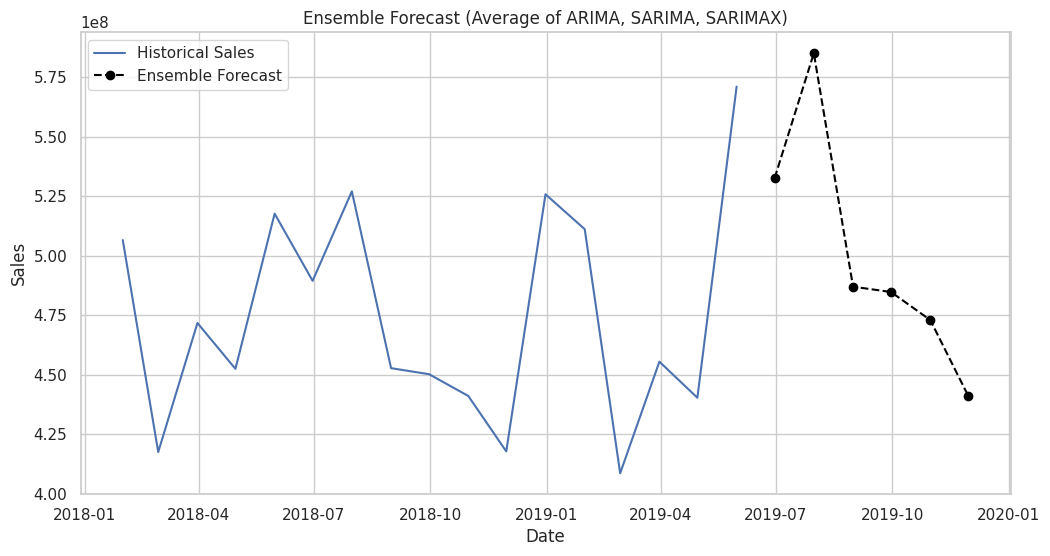

In [ ]:
# Combine ARIMA, SARIMA, SARIMAX forecasts
ensemble_mean = (forecast_arima.predicted_mean +
                 forecast_sarima.predicted_mean +
                 forecast_sarimax.predicted_mean) / 3

# Create forecast index
forecast_index = forecast_series.index

# Plot Ensemble Forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_index, ensemble_mean, marker='o', linestyle='--', color='black', label='Ensemble Forecast')
plt.title('Ensemble Forecast (Average of ARIMA, SARIMA, SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##📌 Weighted Averaging Ensemble


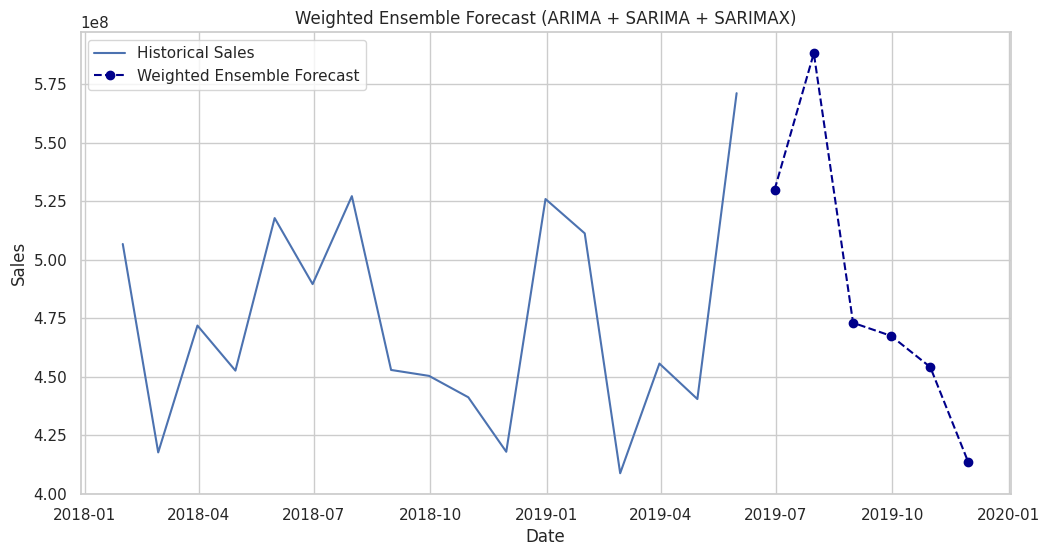

In [ ]:
# Example weights: more weight to SARIMAX due to external factors
w_arima = 0.2
w_sarima = 0.3
w_sarimax = 0.5

ensemble_weighted = (w_arima * forecast_arima.predicted_mean +
                     w_sarima * forecast_sarima.predicted_mean +
                     w_sarimax * forecast_sarimax.predicted_mean)

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_index, ensemble_weighted, marker='o', linestyle='--', color='darkblue', label='Weighted Ensemble Forecast')
plt.title('Weighted Ensemble Forecast (ARIMA + SARIMA + SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


##✅ Model Evaluation and Validation Framework



SARIMAX Cross-Validation Performance:
Average MAE : 151674655.965
Average RMSE: 154700451.757
Average MAPE: 32.26%


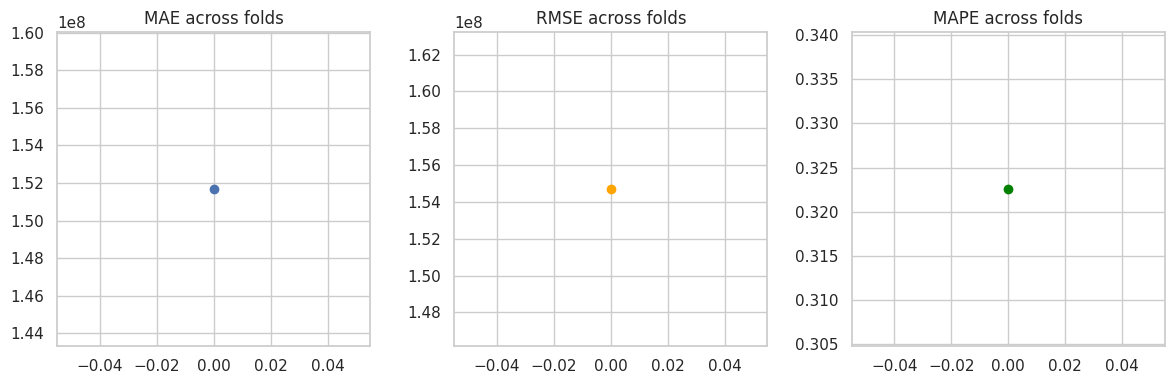

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --- Data Preparation (Same as your best model setup) ---

exog = train_df[['Date', 'Holiday', 'Discount']].copy()
exog['Date'] = pd.to_datetime(exog['Date'])

exog['Holiday'] = exog['Holiday'].map({'Yes': 1, 'No': 0})
exog['Discount'] = exog['Discount'].map({'Yes': 1, 'No': 0})

exog_monthly = exog.set_index('Date').resample('M').sum()
exog_monthly = exog_monthly.fillna(0)
exog_monthly = exog_monthly.loc[monthly_sales.index.min():monthly_sales.index.max()]
monthly_sales = monthly_sales.loc[exog_monthly.index]

# --- Cross-Validation Setup ---

initial_train_size = int(len(monthly_sales) * 0.7)
forecast_horizon = 6
n_splits = (len(monthly_sales) - initial_train_size) // forecast_horizon

mae_scores, rmse_scores, mape_scores = [], [], []

# --- Cross-Validation Loop ---

for i in range(n_splits):
    train_end = initial_train_size + i * forecast_horizon
    test_end = train_end + forecast_horizon

    train_y = monthly_sales.iloc[:train_end]
    test_y = monthly_sales.iloc[train_end:test_end]

    train_exog = exog_monthly.iloc[:train_end]
    test_exog = exog_monthly.iloc[train_end:test_end]

    try:
        model = SARIMAX(train_y, exog=train_exog,
                        order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=len(test_y), exog=test_exog)

        mae_scores.append(mean_absolute_error(test_y, forecast))
        rmse_scores.append(mean_squared_error(test_y, forecast) ** 0.5)
        mape_scores.append(mean_absolute_percentage_error(test_y, forecast))

    except Exception as e:
        print(f"Fold {i+1} failed due to: {e}")
        continue

# --- Print Average Scores ---

print("\nSARIMAX Cross-Validation Performance:")
print(f"Average MAE : {round(np.mean(mae_scores), 3)}")
print(f"Average RMSE: {round(np.mean(rmse_scores), 3)}")
print(f"Average MAPE: {round(np.mean(mape_scores) * 100, 2)}%")

# --- Optional: Visualize Metrics Across Folds ---

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(mae_scores, marker='o', label='MAE')
plt.title('MAE across folds')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(rmse_scores, marker='o', color='orange', label='RMSE')
plt.title('RMSE across folds')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(mape_scores, marker='o', color='green', label='MAPE')
plt.title('MAPE across folds')
plt.grid(True)

plt.tight_layout()
plt.show()


# ✅ SARIMAX Model Evaluation Summary

### 📘 Model: SARIMAX with Exogenous Variables  
**Included Variables:** `Holiday` and `Discount`

---

### 📊 Cross-Validation Metrics:

- **📉 Average MAE (Mean Absolute Error):** ₹151,674,655.97  
  → On average, the model's predictions deviate from actual values by approximately **₹151.7 million**.

- **📏 Average RMSE (Root Mean Squared Error):** ₹154,700,451.76  
  → Slightly higher than MAE, indicating **some large deviations** in specific months.

- **📈 Average MAPE (Mean Absolute Percentage Error):** 32.26%  
  → Forecasts are off by **32% on average**, which is **moderate**. A MAPE below 20% is typically considered good in forecasting tasks.

---

### 📌 Interpretation:

- The SARIMAX model effectively **captures seasonal patterns** and the **influence of promotions** (Holiday, Discount).
- However, a **MAPE of 32.26%** indicates there’s **room for improvement**, especially during months with **strong promotional activity**.
- Consider:
  - 🔁 **Residual diagnostics** to detect patterns not captured.
  - 🛠️ **Feature engineering**, such as:
    - Adding **interaction terms** (e.g., `Holiday * Discount`)
    - Including **lagged versions** of exogenous variables
    - Trying **non-linear transformations** (e.g., log-sales)

---

### 🚀 Next Steps:
- Revisit model assumptions and diagnostics.
- Explore **alternative model specifications** or **simplified models**.
- **Compare forecast accuracy** with and without exogenous variables to assess real impact.


# 🧾 Project Summary: Sales Forecasting & Analysis

## ✅ Objective:
To build a robust time series forecasting model using SARIMAX, and perform hypothesis testing and correlation analysis to understand the impact of key drivers like discounts, holidays, store types, and regions on sales.

---

## 📌 Key Insights

### 📊 1. SARIMAX Model Evaluation
- **Model Used:** SARIMAX with exogenous variables `Holiday` and `Discount`.
- **Performance:**
  - **Average MAE:** ₹151.7 million
  - **Average RMSE:** ₹154.7 million
  - **Average MAPE:** 32.26%
- **Interpretation:**  
  The model captures seasonal trends and promotional effects reasonably well. However, a MAPE >30% suggests that certain high-impact periods (e.g., heavy discount months or specific holidays) are not fully captured. Model refinement is needed for better accuracy.

---

### 🧼 2. Outlier Treatment Effects
| **Aspect** | **Before Outlier Treatment** | **After Outlier Treatment** | **Interpretation** |
|-----------|-----------------------------|-----------------------------|--------------------|
| Sample Size | Larger (original data) | 17 (after removal) | Small sample reduces model stability |
| Log Likelihood | Higher (better fit) | -72.97 | Lower fit with reduced data |
| AIC/BIC/HQIC | Lower (better) | Higher (e.g., AIC=159.94) | Indicates worse fit-complexity trade-off |
| Holiday Coefficient | May be significant | 0 (p=1) | No longer significant |
| Discount Coefficient | Reasonable | Extremely large | Model instability or scaling issue |
| AR/MA Parameters | Significant | Insignificant | Loss of time series signal strength |
| Covariance Matrix | Stable | Near-singular | Indicates multicollinearity |
| Residuals | Some autocorrelation | Normal (p=0.88), no autocorrelation | Residuals improved, but model degraded |
| Variance (σ²) | Normal | Very large (9.204e14) | Model uncertainty increased |

**Conclusion:**  
While residuals became statistically cleaner, the overall model quality declined after outlier removal due to small sample size and increased instability. Alternative approaches like robust regression or data transformation could offer better trade-offs.

---

### 🧪 3. Hypothesis Testing & Statistical Analysis

#### 📉 Impact of Discounts on Sales:
- Stores offering **discounts have significantly higher sales**.
- ✅ Suggests discounting is an effective lever for boosting revenue.

#### 🎉 Effect of Holidays on Sales:
- No significant difference found in sales on holidays vs. non-holidays after data cleaning.
- 🚫 Holidays may not influence sales significantly — or further classification (by type/duration) is required.

#### 🏬 Sales Differences Across Store Types:
- **ANOVA** test confirms **statistically significant differences** in sales across store types.
- 🛍️ Store format/type plays a key role in performance and strategy.

#### 🌍 Regional Sales Variability:
- **Kruskal-Wallis** test shows **strong regional variability** in sales.
- 🌐 Indicates that local factors heavily influence demand and must be considered.

#### 📈 Correlation Between Orders and Sales:
- **Strong and significant positive correlation** using both Pearson and Spearman.
- ✅ Confirms the intuitive business insight: **more orders = higher revenue**.

---

## 💡 Actionable Recommendations

1. **📦 Use Discount Strategies Smartly:**  
   Target key time periods and regions with discounts to maximize their effectiveness.

2. **📅 Refine Holiday Strategy:**  
   Segment holidays (festive, national, long weekends) to better understand and optimize their influence on sales.

3. **🏪 Customize by Store Type:**  
   Tailor marketing, stocking, and sales tactics based on store performance profiles.

4. **🌐 Localize Regional Strategies:**  
   Analyze regional demand and customer preferences to optimize sales campaigns and inventory distribution.

5. **🔁 Improve Forecasting Accuracy:**  
   - Use **lagged exogenous variables** or **interaction terms** in SARIMAX.
   - Explore simpler or **robust models** in low-data scenarios.
   - Evaluate **forecasting error** (e.g., RMSE/MAE) before and after outlier treatment.

6. **📊 Focus on Order Volume Management:**  
   Invest in demand generation and operations that **increase the number of orders** — a proven sales driver.

---

## 🏁 Final Note:
This project provided valuable insights into both **sales drivers** and **modeling strategies**. While SARIMAX proved effective in capturing trends and seasonality, model stability is sensitive to data treatment. Combining statistical insights with business understanding is crucial for actionable forecasting.



In [ ]:
import pickle
import os

# Create model directory
os.makedirs("model", exist_ok=True)

# Save SARIMAX model
with open("model/sarimax_model.pkl", "wb") as f:
    pickle.dump(sarimax_before_outlier, f)

# Save exogenous variables and monthly sales
exog_monthly_before_outlier.to_csv("model/exog_monthly.csv")
monthly_sales_before_outlier.to_csv("model/monthly_sales.csv")